# Networks of persons in relation to organisations


* Pajek book chapter ...
* Cf. [this notebook](https://github.com/Sciences-historiques-numeriques/histoire_numerique_methodes/blob/main/analyse_reseaux/networkx_slicing_with_cores.ipynb) avec simple examples



In [1]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd


import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import seaborn as sns
import math
import os

In [2]:
### Librairies déjà installées avec Python
import pprint
import csv

import sqlite3 as sql

import time
import datetime
from dateutil import parser


from shutil import copyfile


In [3]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

import sys
from importlib import reload

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf
import network_analysis_functions as naf

In [4]:
print(reload(naf))  

<module 'network_analysis_functions' from 'c:\\Users\\tangu\\Documents\\UNINE\\BA4\\Application de méthodes numériques\\Projet\\network_analysis_functions.py'>


## Get the data from the triplestore

...  [compléter]


In [7]:
## define SPARQL enpoint
endpoint = "https://ag1mftakvrjmpfvp.allegrograph.cloud/repositories/judges"

In [8]:
query = """

PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX crm: <http://www.cidoc-crm.org/cidoc-crm/>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>


SELECT ?person (MIN(?pLabel) AS ?personLabel)
        (MIN(?birthYear) AS ?birthYear)
        ?relationship 
        ?organisation (MIN(?oLabel) AS ?organisationLabel)
        (COUNT(*) as ?n) 
        (GROUP_CONCAT(DISTINCT ?groupTypeLabel; separator=" | ") AS ?groupTypes) 
        #(GROUP_CONCAT(DISTINCT ?countryLabel; separator=" | ") AS ?countries) 

WHERE {
        GRAPH <https://github.com/TanguyGodat/Judges/blob/main/graphs/wikidata_imported_data.md>
        {
        {?person a wd:Q5;
           rdfs:label ?pLabel;
           wdt:P569 ?birthYear.
        }


        {?person wdt:P108 ?organisation.
        BIND('employment' AS ?relationship)
        }   
        UNION
        {?person wdt:P463 ?organisation.
        BIND('membership' AS ?relationship)
        }   
        UNION
        {?person wdt:P69 ?organisation.
        BIND('education' AS ?relationship)
        }  
        ?organisation rdfs:label ?oLabel;
                 wdt:P31 ?groupType.
        ?groupType rdfs:label ?groupTypeLabel         
        
        # OPTIONAL {
        #    ?organisation wdt:P17 ?country.
        #    ?country rdfs:label ?countryLabel.
        # }

         }        



    }

GROUP BY ?person ?relationship ?organisation   
ORDER by ?person 
"""

In [9]:
### Executer la requête avec les fonctions de la librairie locale
try:
    qr = spqf.get_json_sparql_result(endpoint,query)
    out = [l for l in spqf.sparql_result_to_list(qr)]
    print(len(out))
    pprint.pprint(out[100:103])
except Exception as e:
    print(e)    


38046
[['http://www.wikidata.org/entity/Q101109361',
  'Paweł Juszczyszyn',
  '1972',
  'education',
  'http://www.wikidata.org/entity/Q1752712',
  'Nicolaus Copernicus University in Toruń',
  '2',
  'open-access publisher | university'],
 ['http://www.wikidata.org/entity/Q101109361',
  'Paweł Juszczyszyn',
  '1972',
  'membership',
  'http://www.wikidata.org/entity/Q9346291',
  'Polish Judges Association "Iustitia"',
  '1',
  'association'],
 ['http://www.wikidata.org/entity/Q101131',
  'Michael Eichberger',
  '1953',
  'education',
  'http://www.wikidata.org/entity/Q317070',
  'University of Mannheim',
  '2',
  'organization | public university']]


## Inspect the data


In [10]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(out)
df_p.columns = ['uriPer', 'labelPer', 'birthYear', 'relaType', 'uriOrg', 'labelOrg', 'nTypes',
                'typesO']
print('Number: ',len(df_p))
df_p.iloc[10:13,:]


Number:  38046


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesO
10,http://www.wikidata.org/entity/Q1001480,Ferenc Finkey,1870,membership,http://www.wikidata.org/entity/Q265058,Hungarian Academy of Sciences,4,public body | national academy | organization ...
11,http://www.wikidata.org/entity/Q1001480,Ferenc Finkey,1870,employment,http://www.wikidata.org/entity/Q1187444,University of Pécs,1,university
12,http://www.wikidata.org/entity/Q1001480,Ferenc Finkey,1870,education,http://www.wikidata.org/entity/Q1115639,Franz Joseph University,1,university


### Distribution of relationships in relation to birthYears

In [11]:
l_50 = list(range(1751, 2051, 50))
print(l_50)

[1751, 1801, 1851, 1901, 1951, 2001]


In [67]:
### We adapt the periods manually
lc = [1751, 1801, 1851, 1901, 1921, 1941, 1961, 1981, 2001]
lc = list(range(1800, 2001, 25))
print(lc)

[1800, 1825, 1850, 1875, 1900, 1925, 1950, 1975, 2000]


In [68]:
### convert birthYear to integer
df_p.birthYear = df_p.birthYear.apply(lambda x : int(x))

In [69]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année
df_p['periods'] = pd.cut(df_p['birthYear'], lc, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_p['periods'] = df_p['periods'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_p.head(3)

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesO,periods,listTypesO,listTokensTypesO,BeginY,EndY
0,http://www.wikidata.org/entity/Q1000023,Wiltraut Rupp-von Brünneck,1912,membership,http://www.wikidata.org/entity/Q119239,National Socialist Women's League,1,women's wing,1900-1924,[women's wing],"[wing, women's]",NaN,NaN
1,http://www.wikidata.org/entity/Q1000439,Bud Cullen,1927,education,http://www.wikidata.org/entity/Q180865,University of Toronto,3,public research university | collegiate univer...,1925-1949,"[collegiate university, public research univer...","[collegiate, ontario, public, research, univer...",1945.0,1956.0
2,http://www.wikidata.org/entity/Q1000788,Buddha Scheidegger,1940,membership,http://www.wikidata.org/entity/Q103860997,Q103860997,1,musical group,1925-1949,[musical group],"[group, musical]",NaN,NaN


#### Save dataframe to CSV

In [70]:
file_add = 'data/persons_organisations.csv'
df_p.to_csv(file_add, index=False, sep=',', quotechar='"')

In [71]:
### load from CSV

file_add = 'data/persons_organisations.csv'
df_p=pd.read_csv(file_add)
print(len(df_p))
df_p.head(2)

38046


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesO,periods,listTypesO,listTokensTypesO,BeginY,EndY
0,http://www.wikidata.org/entity/Q1000023,Wiltraut Rupp-von Brünneck,1912,membership,http://www.wikidata.org/entity/Q119239,National Socialist Women's League,1,women's wing,1900-1924,"[""women's wing""]","['wing', ""women's""]",NaN,NaN
1,http://www.wikidata.org/entity/Q1000439,Bud Cullen,1927,education,http://www.wikidata.org/entity/Q180865,University of Toronto,3,public research university | collegiate univer...,1925-1949,"['collegiate university', 'public research uni...","['collegiate', 'ontario', 'public', 'research'...",1945.0,1956.0


In [72]:
### Group by periods
df_period = df_p.groupby(by='periods', observed=True).size()
print(df_period)

periods
1800-1824     1646
1825-1849     2209
1850-1874     3116
1875-1899     4219
1900-1924     6263
1925-1949    10807
1950-1974     9205
1975-1999      540
dtype: int64


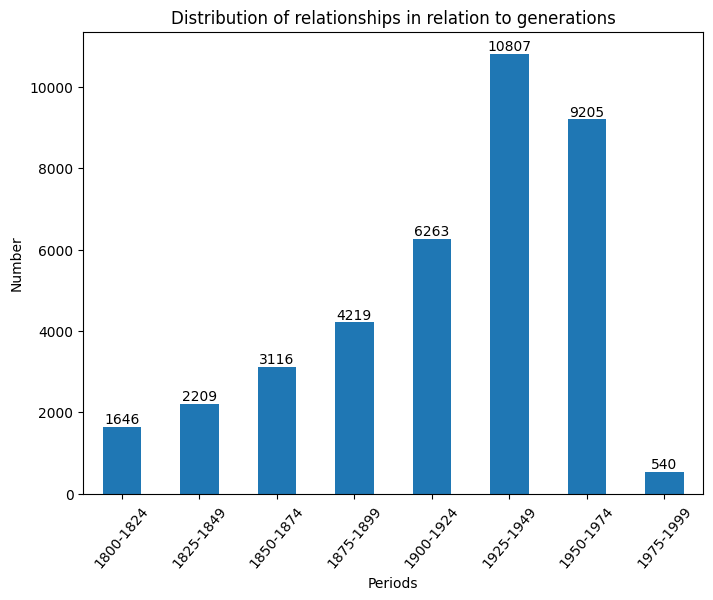

In [73]:
ax = df_period.plot(kind='bar',rot=50, fontsize=10, figsize=(8,6))
ax.bar_label(ax.containers[-1], size=10)
plt.ylabel('Number')
plt.xlabel('Periods')
plt.title('Distribution of relationships in relation to generations')
plt.show()

### Types of organisations

In [74]:
### convert birthYear to integer
df_p['listTypesO'] = df_p.typesO.apply(lambda x : sorted([e.strip().lower() for e in x.split('|')]))

# decompose in the tokens, unique
df_p['listTokensTypesO'] = df_p.listTypesO.apply(lambda x : sorted(list(set([e for e in (' '.join(x)).split(' ') if len(e) > 2]))))

pprint.pprint(df_p.head().listTypesO.to_list())
print('-----')
pprint.pprint(df_p.head().listTokensTypesO.to_list())

[["women's wing"],
 ['collegiate university',
  'public research university',
  'university in ontario'],
 ['musical group'],
 ['civil service', 'government agency'],
 ['international court']]
-----
[['wing', "women's"],
 ['collegiate', 'ontario', 'public', 'research', 'university'],
 ['group', 'musical'],
 ['agency', 'civil', 'government', 'service'],
 ['court', 'international']]


In [75]:
ll = df_p.listTypesO.to_list()
print(len(ll))
print(ll[:3])

38046
[["women's wing"], ['collegiate university', 'public research university', 'university in ontario'], ['musical group']]


In [76]:
llj = [' | '.join(b) for b in ll]
print(len(llj))
print(llj[:3])

38046
["women's wing", 'collegiate university | public research university | university in ontario', 'musical group']


In [77]:
ls = pd.Series(llj)
ltg = pd.DataFrame(ls.groupby(by=ls).size().sort_values(ascending=False))
ltg.reset_index(inplace=True)
ltg.columns=['orgType_group', 'effectif']
ltg.head()


,orgType_group,effectif
0,law school,4047
1,university,1357
2,open-access publisher | public university,893
3,public university,854
4,high school,826


In [78]:
csv_file='data/network_organisations_types_groups.csv'
ltg.to_csv(csv_file)
print(ltg.iloc[30:40])

                                        orgType_group  effectif
30                faculty | law school | organization       227
31      faculty | faculty of law | research institute       217
32  public educational institution of the united s...       215
33                                     faculty of law       214
34  academic publisher | colonial colleges | priva...       210
35                     public university | university       208
36  educational institution | inns of court | univ...       175
37                                      inns of court       166
38  open-access publisher | public research univer...       165
39  learned society | national academy | non-gover...       153


#### Wikidata 'instance of'

In [79]:
ll = df_p.listTypesO.to_list()
print(len(ll))

38046


In [80]:
ltt = [a for b in df_p.listTypesO.to_list() for a in b]
print(len(ltt))

84819


In [81]:
ls = pd.Series(ltt)


In [82]:
ltg = pd.DataFrame(ls.groupby(by=ls).size().sort_values(ascending=False))
ltg.reset_index(inplace=True)
ltg.columns=['organisation', 'effectif']
ltg.head()


,organisation,effectif
0,law school,6580
1,university,5845
2,public university,5806
3,open-access publisher,5408
4,private not-for-profit educational institution,5008


In [83]:
csv_file='data/network_organisations_types.csv'
ltg.to_csv(csv_file)
print(ltg.iloc[30:40])

                              organisation  effectif
30            higher education institution       586
31                    liberal arts college       566
32     college of the university of oxford       565
33                         learned society       506
34                        national academy       504
35                      research institute       501
36  college of the university of cambridge       467
37                           public school       433
38                 local internet registry       405
39                        secondary school       398


#### Wikidata tokens of 'instance of'

In [84]:
ll = df_p.listTokensTypesO.to_list()
print(len(ll))

38046


In [85]:
ltt = [a for b in df_p.listTokensTypesO.to_list() for a in b]
print(len(ltt))

171284


In [86]:
ls = pd.Series(ltt)
ltg = pd.DataFrame(ls.groupby(by=ls).size().sort_values(ascending=False))
ltg.reset_index(inplace=True)
ltg.columns=['token', 'effectif']
ltg.head()


,token,effectif
0,university,19487
1,public,10566
2,school,10305
3,institution,10236
4,educational,9846


In [87]:
csv_file='data/network_organisations_types_tokens.csv'
ltg.to_csv(csv_file)
print(ltg.iloc[30:40])

          token  effectif
30     national       873
31      academy       848
32     boarding       800
33     graduate       752
34   excellence       725
35    nonprofit       704
36    education       699
37       higher       697
38      federal       689
39  independent       669


### Add education period

In [88]:
### Add constructed education period
df_p['BeginY'] = df_p[df_p.relaType=='education'].birthYear.apply(lambda x : x + 18)
df_p['EndY'] = df_p[df_p.relaType=='education'].birthYear.apply(lambda x : x + 29)
df_p.iloc[5:9]

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesO,periods,listTypesO,listTokensTypesO,BeginY,EndY
5,http://www.wikidata.org/entity/Q1001445,Budislav Vukas,1938,employment,http://www.wikidata.org/entity/Q675848,University of Zagreb,2,open-access publisher | public university,1925-1949,"[open-access publisher, public university]","[open-access, public, publisher, university]",NaN,NaN
6,http://www.wikidata.org/entity/Q1001445,Budislav Vukas,1938,education,http://www.wikidata.org/entity/Q675848,University of Zagreb,2,open-access publisher | public university,1925-1949,"[open-access publisher, public university]","[open-access, public, publisher, university]",1956.0,1967.0
7,http://www.wikidata.org/entity/Q1001445,Budislav Vukas,1938,membership,http://www.wikidata.org/entity/Q115095,Institut de Droit International,4,national academy | learned society | nonprofit...,1925-1949,"[learned society, national academy, non-govern...","[academy, learned, national, non-governmental,...",NaN,NaN
8,http://www.wikidata.org/entity/Q1001445,Budislav Vukas,1938,employment,http://www.wikidata.org/entity/Q182016,United Nations Environment Programme,3,environmental organization | organization esta...,1925-1949,"[environmental organization, nonprofit organiz...","[environmental, established, nations, nonprofi...",NaN,NaN


## Create graph for a given period


This is a graph of type 'bipartite', cf. :

https://networkx.org/documentation/stable/reference/algorithms/bipartite.html


We do not use here the functions related to this kind of graph

In [89]:
df_p_1900 = df_p[df_p.periods=='1900-1924'].copy(deep=True)
#pprint.pprint(df_p_1901.head(2).to_dict(orient='records'))

df_p_1950 = df_p[df_p.periods=='1950-1974'].copy(deep=True)
#pprint.pprint(df_p_1961.head(2).to_dict(orient='records'))

df_in_use = df_p_1900


In [90]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriPer'], e['uriOrg'],
     {'relaType':e['relaType']}
     )) 
     for e in df_in_use.to_dict(orient='records')]
print(len(l))

6263


In [91]:
bip_g = nx.Graph()

bip_g.add_edges_from(l)
naf.basic_graph_properties(bip_g)

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 5161,
 'number_of_edges': 6141,
 '------': '------',
 'is connected': False,
 'components': 312,
 'density': 0.0004611960004145582}


In [92]:
### Number of types of relationships
le = list(bip_g.edges.data())
# print([e[2]['relaType'] for e in le][:3]) 
srt = pd.Series([e[2]['relaType'] for e in le])
print(srt.groupby(by=srt).size())

education     4687
employment     863
membership     591
dtype: int64


#### Add metadata to nodes

In [93]:
df_p1 = df_in_use[['uriPer','labelPer','birthYear']]
df_p1 = df_p1.drop_duplicates()
df_p1.columns=['uri', 'label', 'birthYear']
df_p1.head(2)

,uri,label,birthYear
0,http://www.wikidata.org/entity/Q1000023,Wiltraut Rupp-von Brünneck,1912
19,http://www.wikidata.org/entity/Q100258409,ʻAbd Allah Fikri Khani,1922


In [94]:
### Add data to nodes

## Prepare data to import
l = dict([(e['uri'],
     {'label':e['label'], 'birthYear':e['birthYear'],
      'bipartite':0}
     ) for e in df_p1.to_dict(orient='records')])
# print(str(l)[:200])

In [95]:

## Add attributes
nx.set_node_attributes(bip_g, l)
pprint.pprint(list(bip_g.nodes.data())[:3])


[('http://www.wikidata.org/entity/Q1000023',
  {'bipartite': 0, 'birthYear': 1912, 'label': 'Wiltraut Rupp-von Brünneck'}),
 ('http://www.wikidata.org/entity/Q119239', {}),
 ('http://www.wikidata.org/entity/Q100258409',
  {'bipartite': 0, 'birthYear': 1922, 'label': 'ʻAbd Allah Fikri Khani'})]


In [96]:
df_p2 = df_in_use[['uriOrg','labelOrg']]
df_p2 = df_p2.drop_duplicates()
df_p2.columns=['uri', 'label']
df_p2.head(2)

,uri,label
0,http://www.wikidata.org/entity/Q119239,National Socialist Women's League
19,http://www.wikidata.org/entity/Q1351317,Damascus University


In [97]:
### Add data to nodes

## Prepare data to import
l = dict([(e['uri'],
     {'label':e['label'],
      'bipartite':1}
     ) for e in df_p2.to_dict(orient='records')])
# print(str(l)[:200])

In [98]:

## Add attributes
nx.set_node_attributes(bip_g, l)
pprint.pprint(list(bip_g.nodes.data())[:3])

[('http://www.wikidata.org/entity/Q1000023',
  {'bipartite': 0, 'birthYear': 1912, 'label': 'Wiltraut Rupp-von Brünneck'}),
 ('http://www.wikidata.org/entity/Q119239',
  {'bipartite': 1, 'label': "National Socialist Women's League"}),
 ('http://www.wikidata.org/entity/Q100258409',
  {'bipartite': 0, 'birthYear': 1922, 'label': 'ʻAbd Allah Fikri Khani'})]


#### Partition 

We can observe that there is one big partition, with approximately 5000 nodes, and around 100 small ones, comprizing 6 nodes or less


We first explore small partitions

In [123]:
### Create a list of graphs, one per component
S = [bip_g.subgraph(c).copy() for c in nx.connected_components(bip_g)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True)
print(len (ln))
print(ln[:5])

312
[[1, 4118], [7, 32], [13, 32], [130, 26], [11, 22]]


In [131]:
### 
li = [7, 13, 130]  #[6, 12, 30]    # [12, 15, 43]
ll = [list(S[i[0]].nodes.data()) for i in ln if i[0] in li ]
pprint.pprint(ll[0][:2])

[('http://www.wikidata.org/entity/Q17413792',
  {'bipartite': 0, 'birthYear': 1923, 'label': 'Washington Trindade'}),
 ('http://www.wikidata.org/entity/Q98927879',
  {'bipartite': 1, 'label': '1946 Constituent Assembly of Brazil'})]


In [132]:
li = li
pG = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    pG = nx.union(pG, S[i])
print(bipartite.is_bipartite(pG))   
naf.basic_graph_properties(pG)

True
{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 90,
 'number_of_edges': 91,
 '------': '------',
 'is connected': False,
 'components': 3,
 'density': 0.02272159800249688}


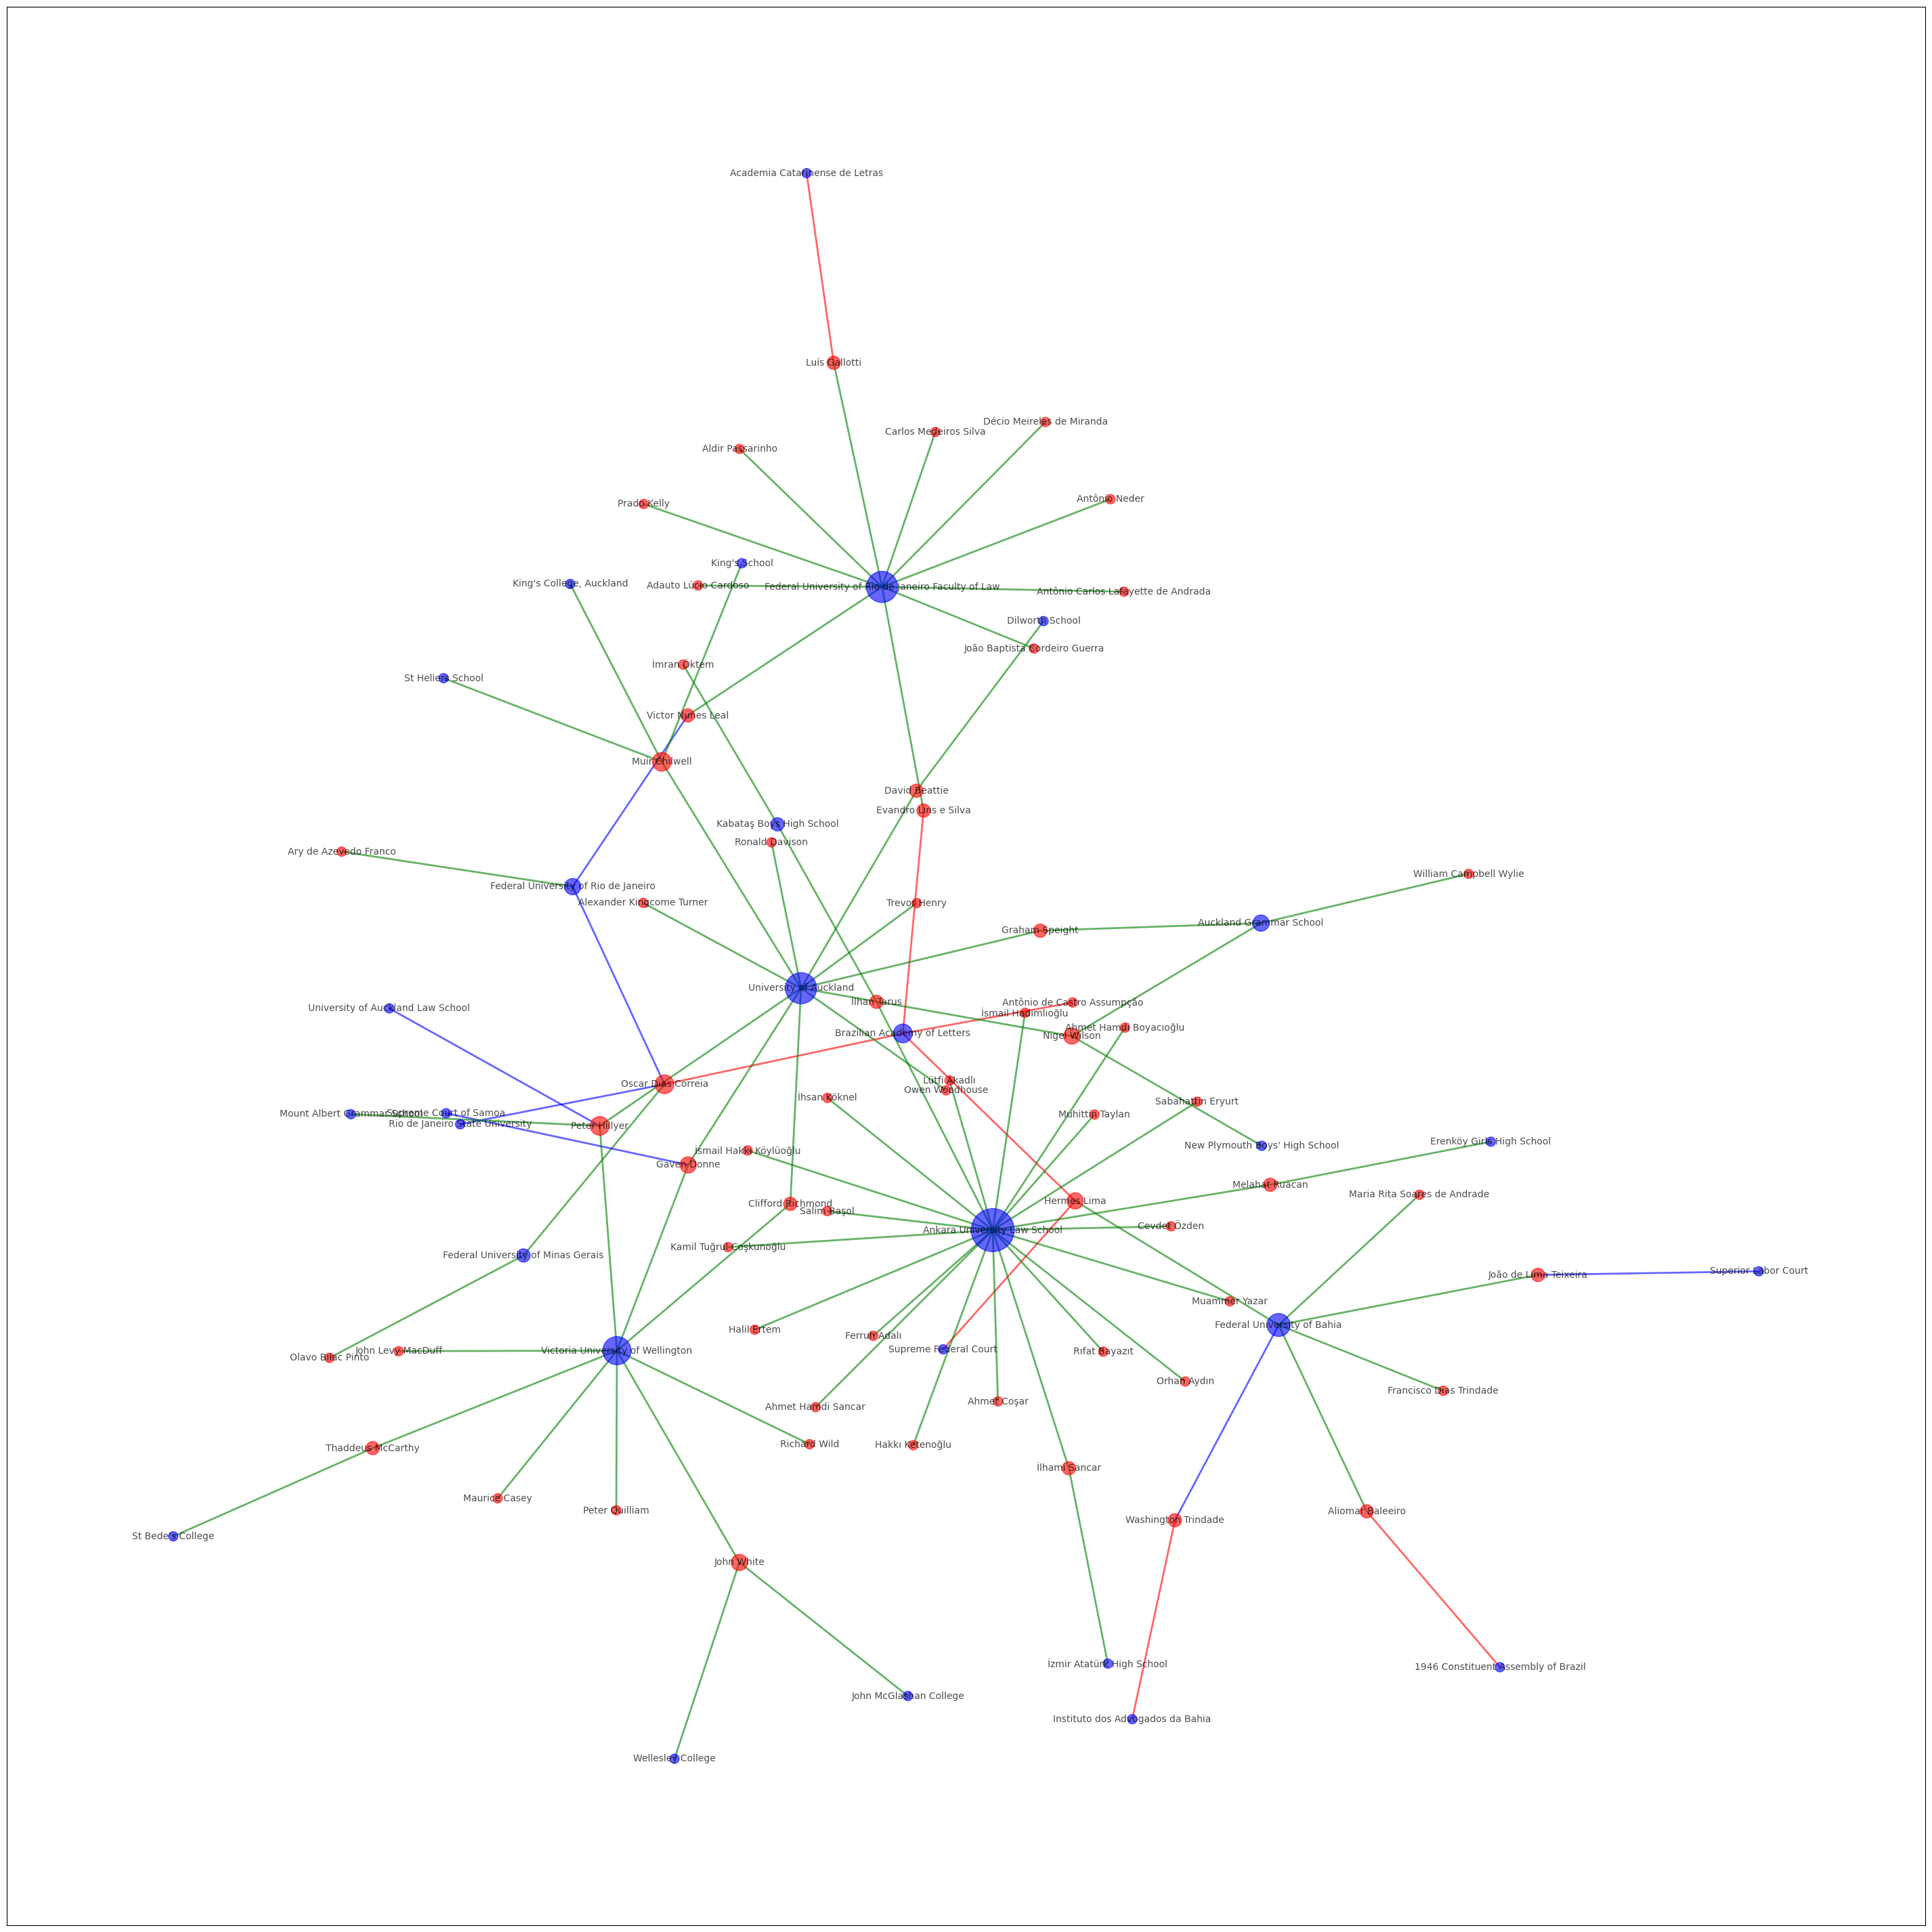

In [133]:
### Plot the graph

g = pG

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'kamada_kawai'
n_k = 0.8
sc = 20

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)

# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [d[1]*100 for d in nx.degree(g)]
node_labels = dict([tuple(( n[0] , n[1]['label'] ))for n in g.nodes.data()])
node_colors = ['red' if n[1]['bipartite'] == 0 else 'blue' for n in g.nodes.data()]
edge_colors = ['blue' if n[2]['relaType'] == 'employment' 
               else 'red' if n[2]['relaType'] == 'membership' 
               else 'green' for n in g.edges.data()]


nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.6)
nx.draw_networkx_edges(g, pos, edge_color=edge_colors, width=2, alpha=0.6) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=10)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=60)
#plt.savefig('images/small_bipartite_component.svg')
plt.show()


#### Biggest component

In [134]:
li = [0]
big_u = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    big_u = nx.union(big_u, S[i])
print(bipartite.is_bipartite(big_u))   
naf.basic_graph_properties(big_u)

True
{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 2,
 'number_of_edges': 1,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 1.0}


In [135]:
### Add degree centrality to nodes
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(big_u)])
nx.set_node_attributes(big_u, degree)
pprint.pprint(list(big_u.nodes.data())[:2])

[('http://www.wikidata.org/entity/Q1000023',
  {'bipartite': 0,
   'birthYear': 1912,
   'degree': 1,
   'label': 'Wiltraut Rupp-von Brünneck'}),
 ('http://www.wikidata.org/entity/Q119239',
  {'bipartite': 1, 'degree': 1, 'label': "National Socialist Women's League"})]


In [136]:
### Add eivenvalue to nodes
eigenvector = nx.eigenvector_centrality(big_u, max_iter=300)
nx.set_node_attributes(big_u, eigenvector, 'eigenvector')
pprint.pprint(list(big_u.nodes.data())[1:3])

[('http://www.wikidata.org/entity/Q119239',
  {'bipartite': 1,
   'degree': 1,
   'eigenvector': 0.7071067811865476,
   'label': "National Socialist Women's League"})]


In [137]:
### A k-core is a maximal subgraph that contains nodes of degree k or more.
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.core.core_number.html#networkx.algorithms.core.core_number

core_numbers = nx.core_number(big_u)
print(str(core_numbers)[:150])

{'http://www.wikidata.org/entity/Q1000023': 1, 'http://www.wikidata.org/entity/Q119239': 1}


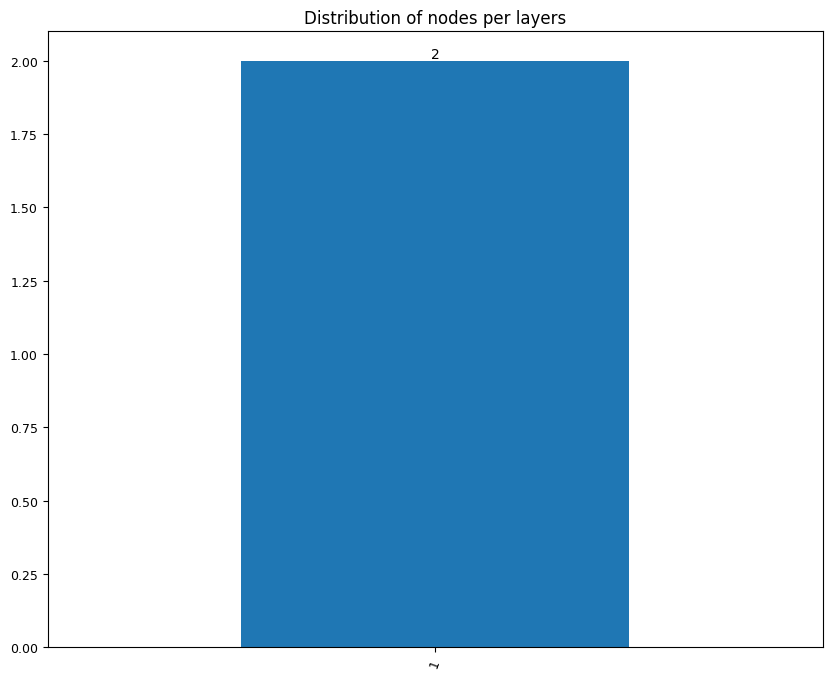

In [138]:
### Distribution of nodes per core layer
l = [v for k,v in core_numbers.items()]
ls = pd.Series(l)
grouped = ls.groupby(ls).size()


ax = grouped.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(10,8))
plt.title('Distribution of nodes per layers')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()


In [139]:
# Identify communities based on core numbers
communities = {}
for node, core_number in core_numbers.items():
    if core_number not in communities:
        communities[core_number] = [node]
    else:
        communities[core_number].append(node)

# Print the communities
cts = []
for core_number, community in communities.items():
    print(f"Community {core_number}: {len(community)}, {community[:5]}")
    cts.append([core_number,len(community),community])



Community 1: 2, ['http://www.wikidata.org/entity/Q1000023', 'http://www.wikidata.org/entity/Q119239']


In [140]:
cts=sorted(cts, key=lambda x: x[0])
p=[pprint.pprint([e[0],e[1],e[2][:3] ]) for e in cts]

[1,
 2,
 ['http://www.wikidata.org/entity/Q1000023',
  'http://www.wikidata.org/entity/Q119239']]


In [141]:
### get all nodes with 
ln = [ k  for k,v in core_numbers.items()  if v >= 6]
print(len(ln), ln[:2])

0 []


In [142]:
cG = big_u.subgraph(ln)
naf.basic_graph_properties(cG)
pprint.pprint(list(cG.nodes.data())[:1])

NetworkXPointlessConcept: Connectivity is undefined for the null graph.

In [143]:
### Same result by using the k_core function
kc_G = nx.k_core(big_u, 6)
naf.basic_graph_properties(kc_G)
pprint.pprint(list(kc_G.nodes.data())[:1])

NetworkXPointlessConcept: Connectivity is undefined for the null graph.

In [150]:
### Plot degree distribution
d = [d[1] for d in nx.degree(kc_G)]
naf.describe_plot_integers_distribution(d,'Degree distribution', (12,6))

count       0
unique      0
top       NaN
freq      NaN
dtype: object


ValueError: Length mismatch: Expected axis has 0 elements, new values have 2 elements

In [151]:
### 

g = kc_G

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 50 #*25

graph_layout = 'spring_layout'
n_k = 0.5
sc = 0.02

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
#print(node_size)

#dict([tuple(( n[0] , n[1]['label'] ))for n in u.nodes.data()])
node_labels =  dict(((u), 
                    str(d['label']))
                    for u, d in g.nodes(data=True))

node_colors = ['red' if n[1]['bipartite'] == 0 else 'blue' for n in g.nodes.data()]

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.1) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_bipartite_component_test.svg')
plt.close()
#plt.plot()

C:\Users\tangu\AppData\Local\Temp\ipykernel_16468\729805951.py:5: RuntimeWarning: divide by zero encountered in log
  n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 50 #*25


ValueError: figure size must be positive finite not (np.float64(-inf), np.float64(-inf))

#### Explore the degree centrality and eigenvector

In [152]:
export = pd.DataFrame(kc_G.nodes.data(), columns = ['id', 'attributes'])
attributes = pd.json_normalize(export.attributes)

export = export.join(pd.json_normalize(export.attributes)).set_index('id')
export.drop(columns=['attributes'], inplace=True)
round(attributes, 3)
export.head(2)
#pprint.pprint(list(nd[:3]))

""
id


In [153]:
### Most frequent persons/organisations by degree or eigenvector (replace in the sort clause !)
## The degree is definitely higher for universities, but the eigenvector can also be high for persons
# and this insofar as they studied in high-degree institutions
export.sort_values(by='eigenvector', ascending=False)[['label', 'bipartite', 'degree', 'eigenvector']].iloc[:20]

KeyError: 'eigenvector'

In [154]:
### https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
# Different colors per class : https://vitalflux.com/python-scatter-plot-different-classes/
# Legend : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
# Labels : https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point


### Please note the filter !
#  
## Values 0 : persons, 1 : organisations  / change rows iloc filter if needed ! 
exp = export[export.bipartite==0].sort_values(by='eigenvector', ascending=False).iloc[:30]

### Adapt image size and police
plt.figure(figsize=(10, 20))

## Please consider:
## https://how2matplotlib.com/matplotlib-scatter-label.html

plt.scatter(exp['degree'][(exp.bipartite == 0)], 
            exp['eigenvector'][(exp.bipartite == 0)],
           marker='o',
           color='Coral',
           label='pers'
           )
plt.scatter(exp['degree'][(exp.bipartite == 1)], #  | (exp.Parti == 'MED')],
            exp['eigenvector'][(exp.bipartite == 1)], #  | (exp.Parti == 'MED')],
           marker='D',
           color='DarkCyan',
           label='org')
plt.xlabel('degree')
plt.ylabel('eigenvector')

for i,row in list(exp[['label', 'degree','eigenvector']].iterrows()):
    plt.annotate(row['label'],(row['degree'], row['eigenvector']))
plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'bipartite'

In [155]:
### https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
# Different colors per class : https://vitalflux.com/python-scatter-plot-different-classes/
# Legend : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
# Labels : https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point


### Please note the filter !
#  
## Values 0 : persons, 1 : organisations  / change rows iloc filter if needed ! 
exp = export[export.bipartite==1].sort_values(by='eigenvector', ascending=False).iloc[:30]

### Adapt image size and police
plt.figure(figsize=(10, 20))

## Please consider:
## https://how2matplotlib.com/matplotlib-scatter-label.html

plt.scatter(exp['degree'][(exp.bipartite == 0)], 
            exp['eigenvector'][(exp.bipartite == 0)],
           marker='o',
           color='Coral',
           label='pers'
           )
plt.scatter(exp['degree'][(exp.bipartite == 1)], #  | (exp.Parti == 'MED')],
            exp['eigenvector'][(exp.bipartite == 1)], #  | (exp.Parti == 'MED')],
           marker='D',
           color='DarkCyan',
           label='org')
plt.xlabel('degree')
plt.ylabel('eigenvector')

for i,row in list(exp[['label', 'degree','eigenvector']].iterrows()):
    plt.annotate(row['label'],(row['degree'], row['eigenvector']))
plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'bipartite'

## Create graph of persons relationships during studies

In [156]:
print(list(df_p.columns))
df_p.head(2)

['uriPer', 'labelPer', 'birthYear', 'relaType', 'uriOrg', 'labelOrg', 'nTypes', 'typesO', 'periods', 'listTypesO', 'listTokensTypesO', 'BeginY', 'EndY']


,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesO,periods,listTypesO,listTokensTypesO,BeginY,EndY
0,http://www.wikidata.org/entity/Q1000023,Wiltraut Rupp-von Brünneck,1912,membership,http://www.wikidata.org/entity/Q119239,National Socialist Women's League,1,women's wing,1900-1924,[women's wing],"[wing, women's]",NaN,NaN
1,http://www.wikidata.org/entity/Q1000439,Bud Cullen,1927,education,http://www.wikidata.org/entity/Q180865,University of Toronto,3,public research university | collegiate univer...,1925-1949,"[collegiate university, public research univer...","[collegiate, ontario, public, research, univer...",1945.0,1956.0


### Prepare and create the graph

In [157]:
### Select the columns that will be used
df_sel = df_p[df_p.relaType=='education'][['uriPer','uriOrg', 'labelOrg', 'BeginY','EndY', 'periods']].copy(deep=True)
print(len(df_sel))

28443


In [158]:
### Join on common organisation -> produces a lot of rows !
merged = pd.merge(df_sel, df_sel, on=['uriOrg', 'labelOrg'])
print(len(merged))


1812941


In [159]:
### Eliminate double rows :relationship A-B but relationship B-A
merged = merged[merged['uriPer_x'] < (merged['uriPer_y'])]
print(len(merged))

892249


In [160]:
### Restrict time overlap (allow only 8 years overlap) — could be extended to have a larger result
merged = merged[(merged['BeginY_y']+2 < merged['EndY_x']-2) & (merged['BeginY_x']+2 < merged['EndY_y']-2)]
print(len(merged))
merged = merged[['uriPer_x', 'uriPer_y', 'uriOrg', 'labelOrg', 'periods_x', 'BeginY_x', 'EndY_x',  'BeginY_y', 'EndY_y', 'periods_y']]



109335


In [161]:
print(len(merged))
print(list(merged.columns))
merged.head()

109335
['uriPer_x', 'uriPer_y', 'uriOrg', 'labelOrg', 'periods_x', 'BeginY_x', 'EndY_x', 'BeginY_y', 'EndY_y', 'periods_y']


,uriPer_x,uriPer_y,uriOrg,labelOrg,periods_x,BeginY_x,EndY_x,BeginY_y,EndY_y,periods_y
3,http://www.wikidata.org/entity/Q1000439,http://www.wikidata.org/entity/Q109519926,http://www.wikidata.org/entity/Q180865,University of Toronto,1925-1949,1945.0,1956.0,1941.0,1952.0,1900-1924
11,http://www.wikidata.org/entity/Q1000439,http://www.wikidata.org/entity/Q176944,http://www.wikidata.org/entity/Q180865,University of Toronto,1925-1949,1945.0,1956.0,1949.0,1960.0,1925-1949
39,http://www.wikidata.org/entity/Q1001445,http://www.wikidata.org/entity/Q1032788,http://www.wikidata.org/entity/Q675848,University of Zagreb,1925-1949,1956.0,1967.0,1953.0,1964.0,1925-1949
45,http://www.wikidata.org/entity/Q1001445,http://www.wikidata.org/entity/Q6579573,http://www.wikidata.org/entity/Q675848,University of Zagreb,1925-1949,1956.0,1967.0,1954.0,1965.0,1925-1949
64,http://www.wikidata.org/entity/Q100157104,http://www.wikidata.org/entity/Q14945505,http://www.wikidata.org/entity/Q805285,Balliol College,1825-1849,1850.0,1861.0,1850.0,1861.0,1825-1849


In [162]:
### Group by persons' pairs and count/aggregate organisations

## This is needed because the nx.add_edges_from() function applies
# a DISTINCT approach and information will be lost if two persons
# are related by more than one organisation 

gr_mer = merged.groupby(['uriPer_x', 'uriPer_y', 'periods_x', 'BeginY_x', 'EndY_x', 'BeginY_y', 'EndY_y', 'periods_y'], as_index = False)\
    .agg({'labelOrg': '|'.join, 'uriOrg': '|'.join})
gr_mer['number'] = gr_mer.labelOrg.apply(lambda x : len(x.split('|')))
print(len(gr_mer))


104878


In [163]:
### change columns names
gr_mer.columns= ['uriPer_x', 'uriPer_y', 'periods_x', 'BeginY_x', 'EndY_x', 'BeginY_y', 'EndY_y', 'periods_y', 'orgs', 'uriOrgs', 'numberOrgs']

In [164]:
### change columns positions
gr_mer = gr_mer[['uriPer_x', 'uriPer_y', 'orgs', 'numberOrgs', 'uriOrgs', 'periods_x', 'BeginY_x', 'EndY_x', 'BeginY_y', 'EndY_y', 'periods_y']]
gr_mer.head(2)

,uriPer_x,uriPer_y,orgs,numberOrgs,uriOrgs,periods_x,BeginY_x,EndY_x,BeginY_y,EndY_y,periods_y
0,http://www.wikidata.org/entity/Q1000439,http://www.wikidata.org/entity/Q109519926,University of Toronto,1,http://www.wikidata.org/entity/Q180865,1925-1949,1945.0,1956.0,1941.0,1952.0,1900-1924
1,http://www.wikidata.org/entity/Q1000439,http://www.wikidata.org/entity/Q176944,University of Toronto,1,http://www.wikidata.org/entity/Q180865,1925-1949,1945.0,1956.0,1949.0,1960.0,1925-1949


In [165]:
### Store the information from the SPARQL query in a CSV file
# in order to be able to upload it witout executing the query again
file_add = 'data/persons_common_education.csv'
try:
    gr_mer.to_csv(file_add)
    print('Written!')
except Exception as e:
    print(e)


Written!


In [166]:
### sort by multiple relationships
gr_mer[['uriPer_x','uriPer_y','orgs','numberOrgs']].sort_values(by='numberOrgs', ascending=False).iloc[:7]

,uriPer_x,uriPer_y,orgs,numberOrgs
57676,http://www.wikidata.org/entity/Q2633194,http://www.wikidata.org/entity/Q4409483,City College of New York|Brooklyn Law School|p...,3
6166,http://www.wikidata.org/entity/Q108611385,http://www.wikidata.org/entity/Q108709886,University of Lagos|Nigerian Law School|Ahmadu...,3
57912,http://www.wikidata.org/entity/Q26923642,http://www.wikidata.org/entity/Q76898486,Ghana School of Law|Aburi Girls' Senior High S...,3
6696,http://www.wikidata.org/entity/Q108680628,http://www.wikidata.org/entity/Q123759763,University of Nigeria|University of Lagos|Nige...,3
34006,http://www.wikidata.org/entity/Q16115080,http://www.wikidata.org/entity/Q1792585,Mississippi State University|University of Mis...,3
18148,http://www.wikidata.org/entity/Q124526773,http://www.wikidata.org/entity/Q63104521,University of Hawaiʻi System|University of Mic...,3
6128,http://www.wikidata.org/entity/Q108611355,http://www.wikidata.org/entity/Q108709886,University of Lagos|Nigerian Law School|Ahmadu...,3


In [167]:
### store multiple relationships in order to explore them in the CSV
file_add = 'data/persons_education_rel_multiple.csv'
gr_mer[gr_mer.numberOrgs > 1].sort_values(by='numberOrgs', ascending=False).to_csv(file_add)

#### Example of connected persons

Displayed with **Allegrograph Gruff**

<img src="images/alg_gruff_example_chinese_connected_education.png" alt="drawing" width="700"/>

In [168]:
### Find persons in different periods

## We observe that there is significant overlap: more than 30000
# Periods are as a matter of fact an artificial construct !

print(len(gr_mer[gr_mer.periods_x != gr_mer.periods_y]))
gr_mer[gr_mer.periods_x != gr_mer.periods_y].sort_values(by='numberOrgs', ascending=False).iloc[:5]

14742


,uriPer_x,uriPer_y,orgs,numberOrgs,uriOrgs,periods_x,BeginY_x,EndY_x,BeginY_y,EndY_y,periods_y
31741,http://www.wikidata.org/entity/Q16031232,http://www.wikidata.org/entity/Q554988,Columbia Grammar & Preparatory School|Columbia...,3,http://www.wikidata.org/entity/Q5149700|http:/...,1825-1849,1864.0,1875.0,1868.0,1879.0,1850-1874
20122,http://www.wikidata.org/entity/Q12967678,http://www.wikidata.org/entity/Q562584,University of Santo Tomas Faculty of Civil Law...,3,http://www.wikidata.org/entity/Q7896259|http:/...,1850-1874,1871.0,1882.0,1865.0,1876.0,1825-1849
86607,http://www.wikidata.org/entity/Q5568800,http://www.wikidata.org/entity/Q6141063,University of Michigan|University of Michigan ...,3,http://www.wikidata.org/entity/Q230492|http://...,1925-1949,1943.0,1954.0,1942.0,1953.0,1900-1924
94653,http://www.wikidata.org/entity/Q6263083,http://www.wikidata.org/entity/Q7154113,Michigan State University|University of Michig...,3,http://www.wikidata.org/entity/Q270222|http://...,1900-1924,1942.0,1953.0,1947.0,1958.0,1925-1949
95931,http://www.wikidata.org/entity/Q6384856,http://www.wikidata.org/entity/Q6833580,Yale Law School|Harvard University|Harvard Col...,3,http://www.wikidata.org/entity/Q1143289|http:/...,1950-1974,1968.0,1979.0,1964.0,1975.0,1925-1949


### Create the graph

In [169]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriPer_x'], e['uriPer_y'],
     {'orgsUris':e['uriOrgs'], 'orgsLabels':e['orgs'], 'orgsNumber':e['numberOrgs'],   
      'periods_x':e['periods_x'], 'periods_y':e['periods_y']}
     )) 
     for e in gr_mer.to_dict(orient='records')]
print(len(l))

104878


In [170]:
print(len(gr_mer))

104878


In [171]:
## Créate the empty graph
ppG=nx.Graph()

## Add relationships to graph
# Multiple rows between two edges are taken only once
ppG.add_edges_from(l)

naf.basic_graph_properties(ppG)


{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 15200,
 'number_of_edges': 104878,
 '------': '------',
 'is connected': False,
 'components': 684,
 'density': 0.0009079371565303812}


#### Add metadata to nodes

In [172]:
df_pm = df_p[['uriPer','labelPer','birthYear']]
df_pm = df_pm.drop_duplicates()
df_pm.columns=['uri', 'label', 'birthYear']
df_pm.head()


,uri,label,birthYear
0,http://www.wikidata.org/entity/Q1000023,Wiltraut Rupp-von Brünneck,1912
1,http://www.wikidata.org/entity/Q1000439,Bud Cullen,1927
2,http://www.wikidata.org/entity/Q1000788,Buddha Scheidegger,1940
3,http://www.wikidata.org/entity/Q100082643,Donald Campbell Johnstone,1857
4,http://www.wikidata.org/entity/Q1001445,Budislav Vukas,1938


In [173]:
### Prepare data to add to nodes
ln = dict([(e['uri'],
     {'label':e['label'], 'birthYear':e['birthYear']}
     ) for e in df_pm.to_dict(orient='records')])
# print(str(l)[:200])


In [174]:

## Add attributes
nx.set_node_attributes(ppG, ln)
pprint.pprint(list(ppG.nodes.data())[:2])


[('http://www.wikidata.org/entity/Q1000439',
  {'birthYear': 1927, 'label': 'Bud Cullen'}),
 ('http://www.wikidata.org/entity/Q109519926',
  {'birthYear': 1923, 'label': 'Sydney Lewis Robins'})]


## Explore the education relationships graph

In [175]:
naf.basic_graph_properties(ppG)

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 15200,
 'number_of_edges': 104878,
 '------': '------',
 'is connected': False,
 'components': 684,
 'density': 0.0009079371565303812}


#### Components

In [176]:
### Create a list of graphs, one per component
perS = [ppG.subgraph(c).copy() for c in nx.connected_components(ppG)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(perS)], key = lambda row: row[1], reverse=True)
print(ln[:5])

### Again we observe that there is a big connected graphe 
# and a multitude of small graphs

[[0, 12379], [256, 84], [84, 46], [159, 39], [134, 37]]


### Explore small graph

In [177]:
### 
li = [117]    # [12, 15, 43]
ll = [list(perS[i[0]].nodes.data()) for i in ln if i[0] in li ]
#pprint.pprint(str(ll)[:300])

In [178]:

# Display variable

u_117 = nx.Graph()

for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    u_117 = nx.union(u_117, perS[i])
naf.basic_graph_properties(u_117)


{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 18,
 'number_of_edges': 69,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 0.45098039215686275}


{'http://www.wikidata.org/entity/Q17191688': 'Shigeo Abe', 'http://www.wikidata.org/entity/Q18014531': 'Miyazaki Sannosuke', 'http://www.wikidata.org/entity/Q17226368': 'Fusajirō Karato', 'http://www.wikidata.org/entity/Q17215425': 'Sōzō Nozoe', 'http://www.wikidata.org/entity/Q17225313': 'Q17225313', 'http://www.wikidata.org/entity/Q18054632': 'Yasaburō Hayakawa', 'http://www.wikidata.org/entity/Q11467952': 'Kesaya Yamazaki', 'http://www.wikidata.org/entity/Q17217058': 'Shibahiko Uchida', 'http://www.wikidata.org/entity/Q17230555': 'Morishita Kametarō', 'http://www.wikidata.org/entity/Q16264384': 'Yūjirō Iwamoto', 'http://www.wikidata.org/entity/Q11097844': 'Li Zhaofu', 'http://www.wikidata.org/entity/Q17230955': 'Q17230955', 'http://www.wikidata.org/entity/Q17214618': 'Kichiji Kudō', 'http://www.wikidata.org/entity/Q17193581': 'Yasutarō Imamura', 'http://www.wikidata.org/entity/Q17218868': 'Utao Sakuta', 'http://www.wikidata.org/entity/Q20038830': 'Sojuro Iwasaki', 'http://www.wikida

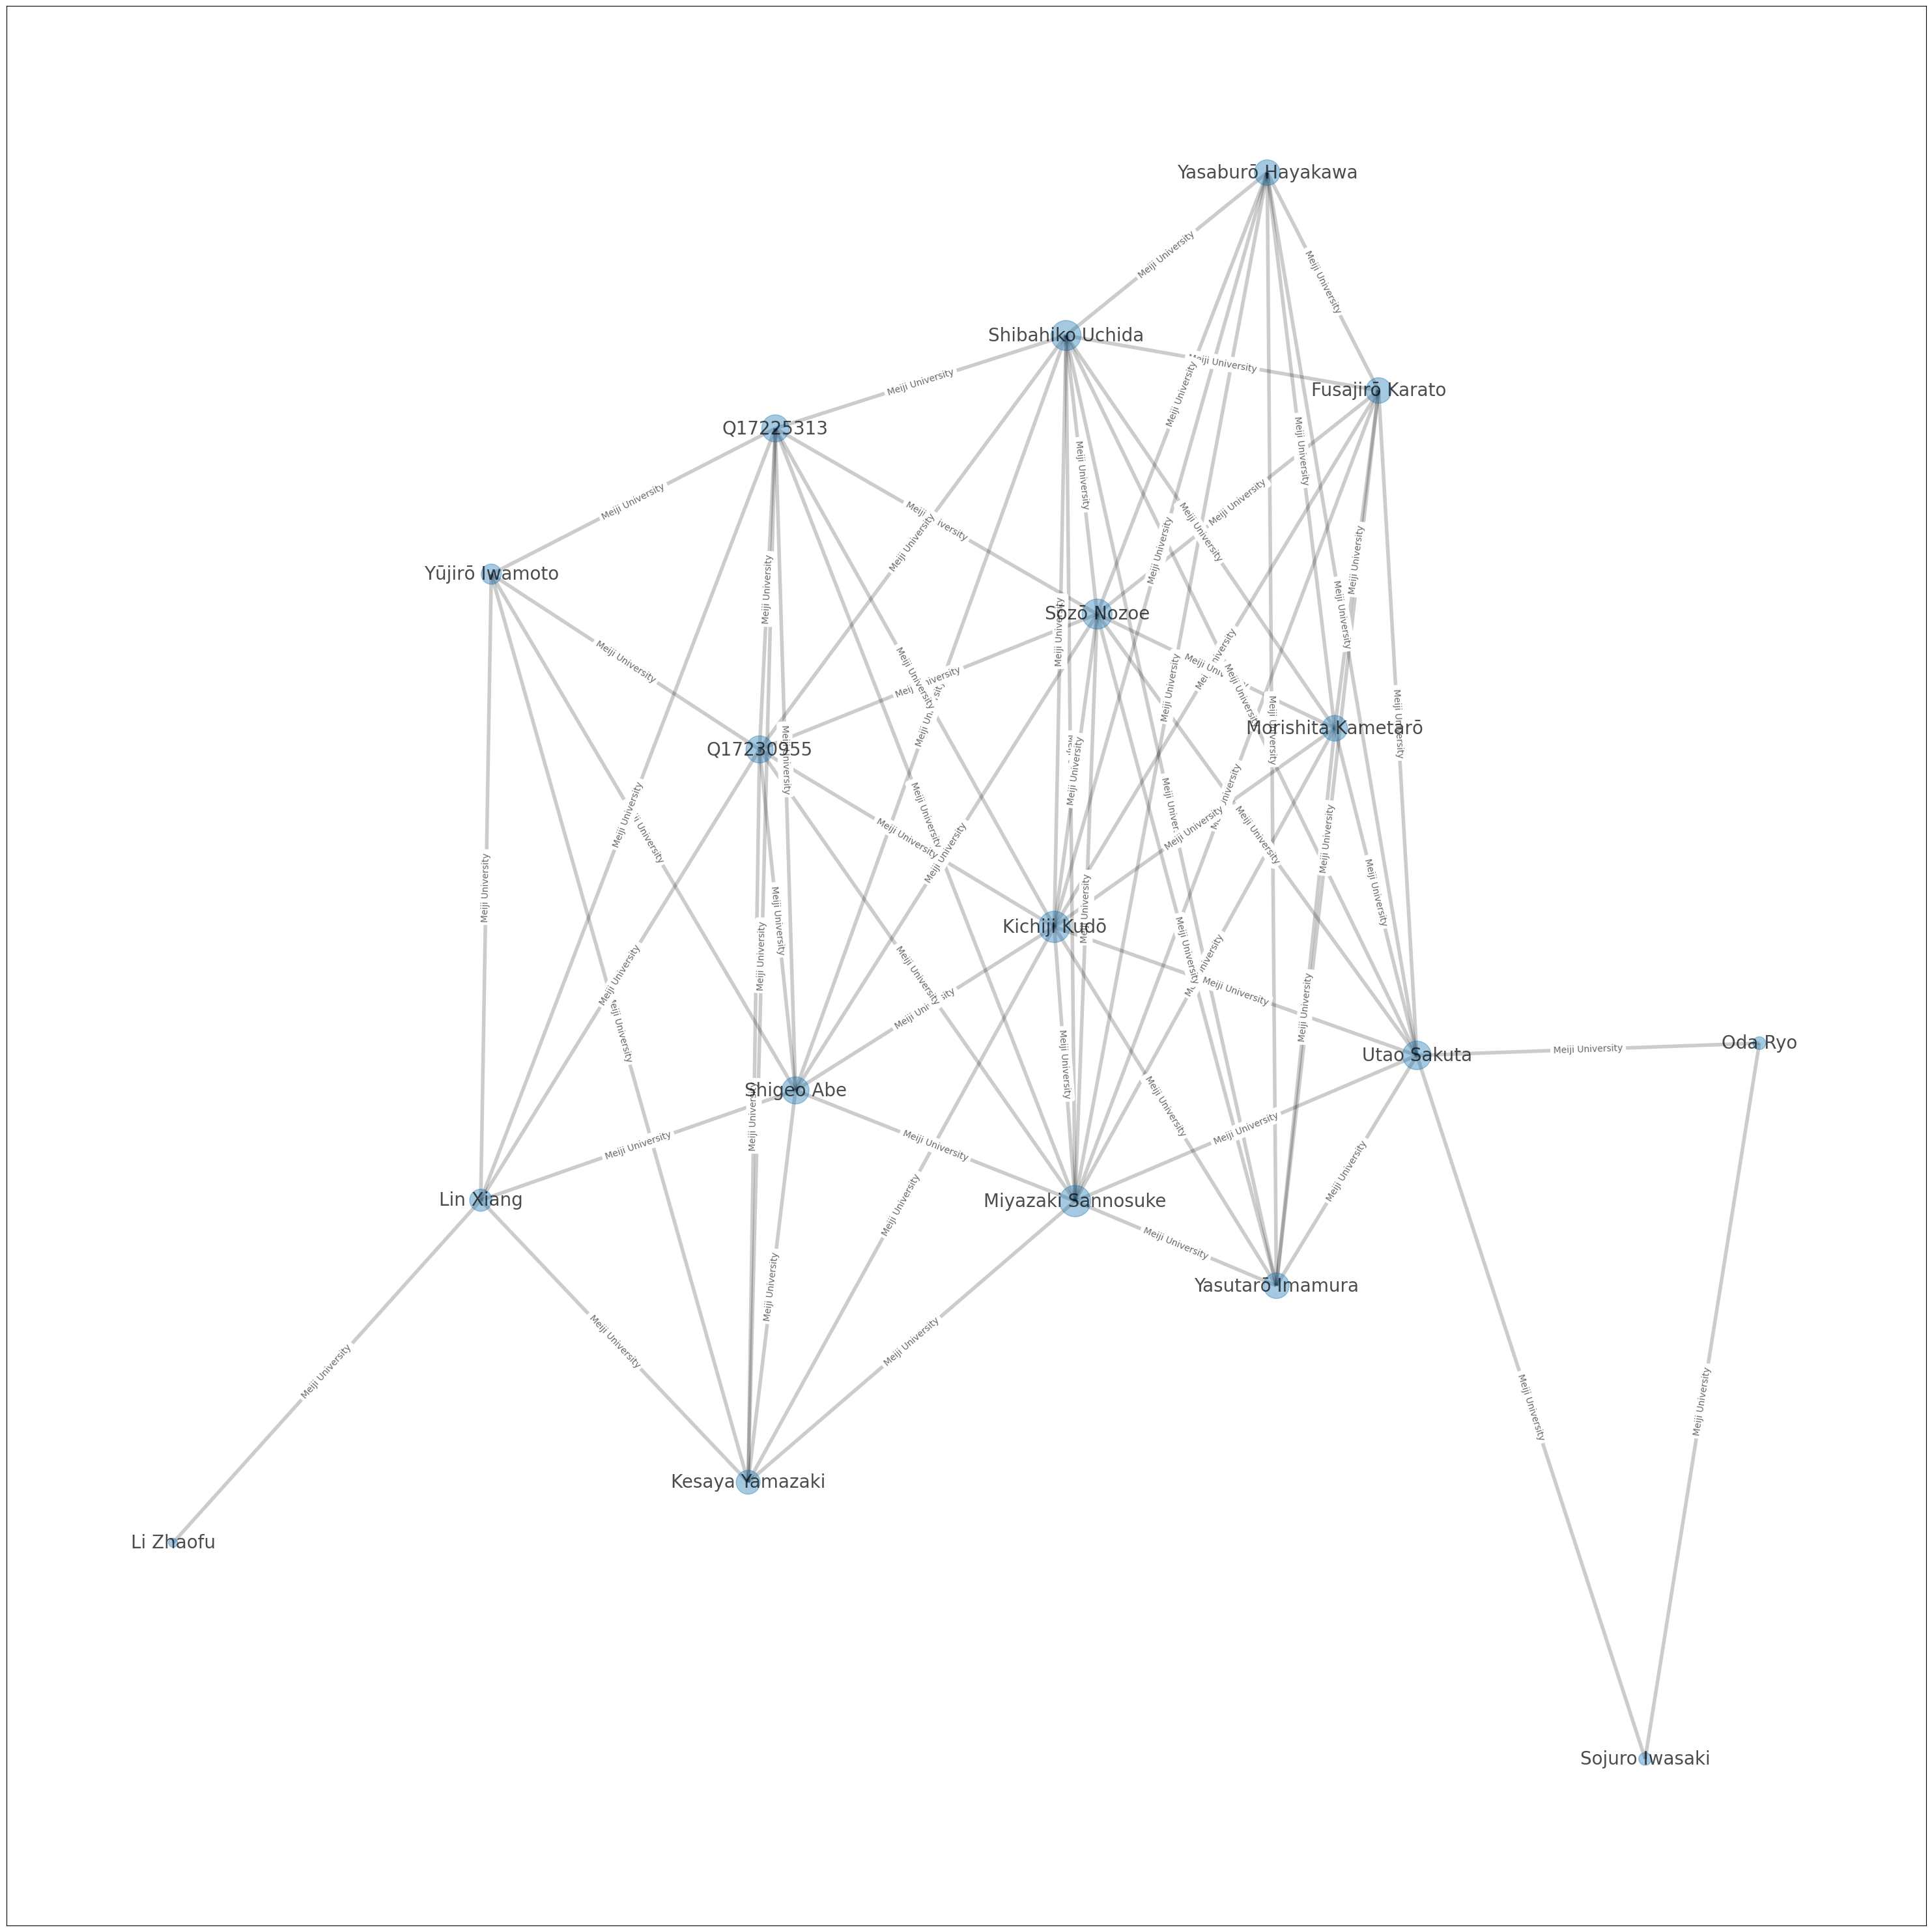

In [179]:
### 

g = u_117

# print(list(g.nodes.data())[:3])
# print(list(g.edges.data())[:3])

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 30 #*25

graph_layout = 'kamada_kawai'
n_k = 0.4
sc = 0.02

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)


# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))

node_size = [d[1]*100 for d in nx.degree(g)]
node_labels = dict([tuple(( n[0] , n[1]['label'] ))for n in g.nodes.data()])
print(node_labels)
edge_labels = {e: g.get_edge_data(e[0], e[1])["orgsLabels"] for e in g.edges()}
print(edge_labels)


### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_size=node_size, alpha=0.4)
nx.draw_networkx_edges(g, pos, label=edge_labels, width=4, alpha=0.2) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.7, font_size=20)
nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=edge_labels, alpha=0.6)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
#plt.savefig('images/small_bipartite_component.svg')
plt.show()


In [180]:
df_p[(df_p.labelOrg.str.contains('Kyiv Poly'))& df_p.relaType.str.contains('educa')].head()

,uriPer,labelPer,birthYear,relaType,uriOrg,labelOrg,nTypes,typesO,periods,listTypesO,listTokensTypesO,BeginY,EndY


#### Composante principale

In [181]:
li = [0]
big_ppG = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    big_ppG = nx.union(big_ppG, perS[i])

naf.basic_graph_properties(big_ppG)



{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 12379,
 'number_of_edges': 99597,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 0.0012999905982787842}


In [182]:
pprint.pprint(list(big_ppG.nodes.data())[:2])

[('http://www.wikidata.org/entity/Q1000439',
  {'birthYear': 1927, 'label': 'Bud Cullen'}),
 ('http://www.wikidata.org/entity/Q109519926',
  {'birthYear': 1923, 'label': 'Sydney Lewis Robins'})]


In [183]:
### Add degree centrality to nodes
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(big_ppG)])
nx.set_node_attributes(big_ppG, degree)
pprint.pprint(list(big_ppG.nodes.data())[:2])


[('http://www.wikidata.org/entity/Q1000439',
  {'birthYear': 1927, 'degree': 2, 'label': 'Bud Cullen'}),
 ('http://www.wikidata.org/entity/Q109519926',
  {'birthYear': 1923, 'degree': 84, 'label': 'Sydney Lewis Robins'})]


### Degree distribution and slicing

In [184]:
### Plot degree distribution
d = [d[1] for d in nx.degree(big_ppG)]
naf.describe_plot_integers_distribution(d, 50,6,'Degree distribution')

TypeError: describe_plot_integers_distribution() takes from 2 to 3 positional arguments but 4 were given

In [185]:
### Add eigenvector to nodes

## If error: PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')
# increase number of max iterations
eigenvector = nx.eigenvector_centrality(big_ppG, max_iter=200)
nx.set_node_attributes(big_ppG, eigenvector, 'eigenvector')
pprint.pprint(list(big_ppG.nodes.data())[:2])

[('http://www.wikidata.org/entity/Q1000439',
  {'birthYear': 1927,
   'degree': 2,
   'eigenvector': 6.852336568875103e-05,
   'label': 'Bud Cullen'}),
 ('http://www.wikidata.org/entity/Q109519926',
  {'birthYear': 1923,
   'degree': 84,
   'eigenvector': 0.0062782570460351815,
   'label': 'Sydney Lewis Robins'})]


In [186]:
### Plot eigenvector density distribution 
eigenvector_s = pd.Series(list(eigenvector.values()))
stats = eigenvector_s.describe()

# Format decimal values
stats = stats.apply(lambda x: format(x, '.20f'))

print(stats)

count    12379.00000000000000000000
mean         0.00147625102584769772
std          0.00886617180992698047
min          0.00000000000000000000
25%          0.00000000000524773565
50%          0.00000029754531300062
75%          0.00004453396923349666
max          0.08419188085759626849
dtype: object


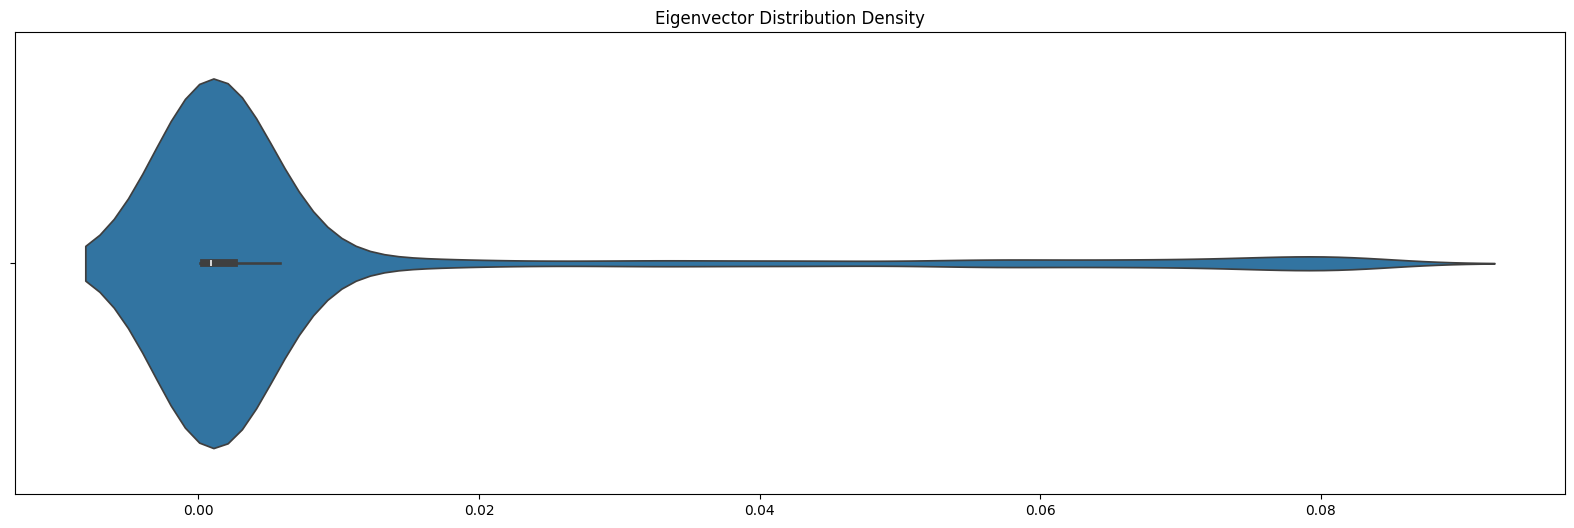

In [187]:
# Plot the distribution of eigenvector density

plt.figure(figsize=(20, 6))
p = sns.violinplot(data=eigenvector_s[eigenvector_s> 0.00013610493515402787], orient='h')
plt.title('Eigenvector Distribution Density')
plt.show()

In [188]:
print(len(eigenvector_s[eigenvector_s> 0.01]))

299


In [189]:
### Export node attributes to dataframe
nodes_data ={node: big_ppG.nodes[node] for node in big_ppG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True)
nodes_df.columns = ['personUri', 'label', 'birthYear','degree','eigenvector']
nodes_df.head(2)

,personUri,label,birthYear,degree,eigenvector
0,http://www.wikidata.org/entity/Q1000439,Bud Cullen,1927,2,0.000069
1,http://www.wikidata.org/entity/Q109519926,Sydney Lewis Robins,1923,84,0.006278


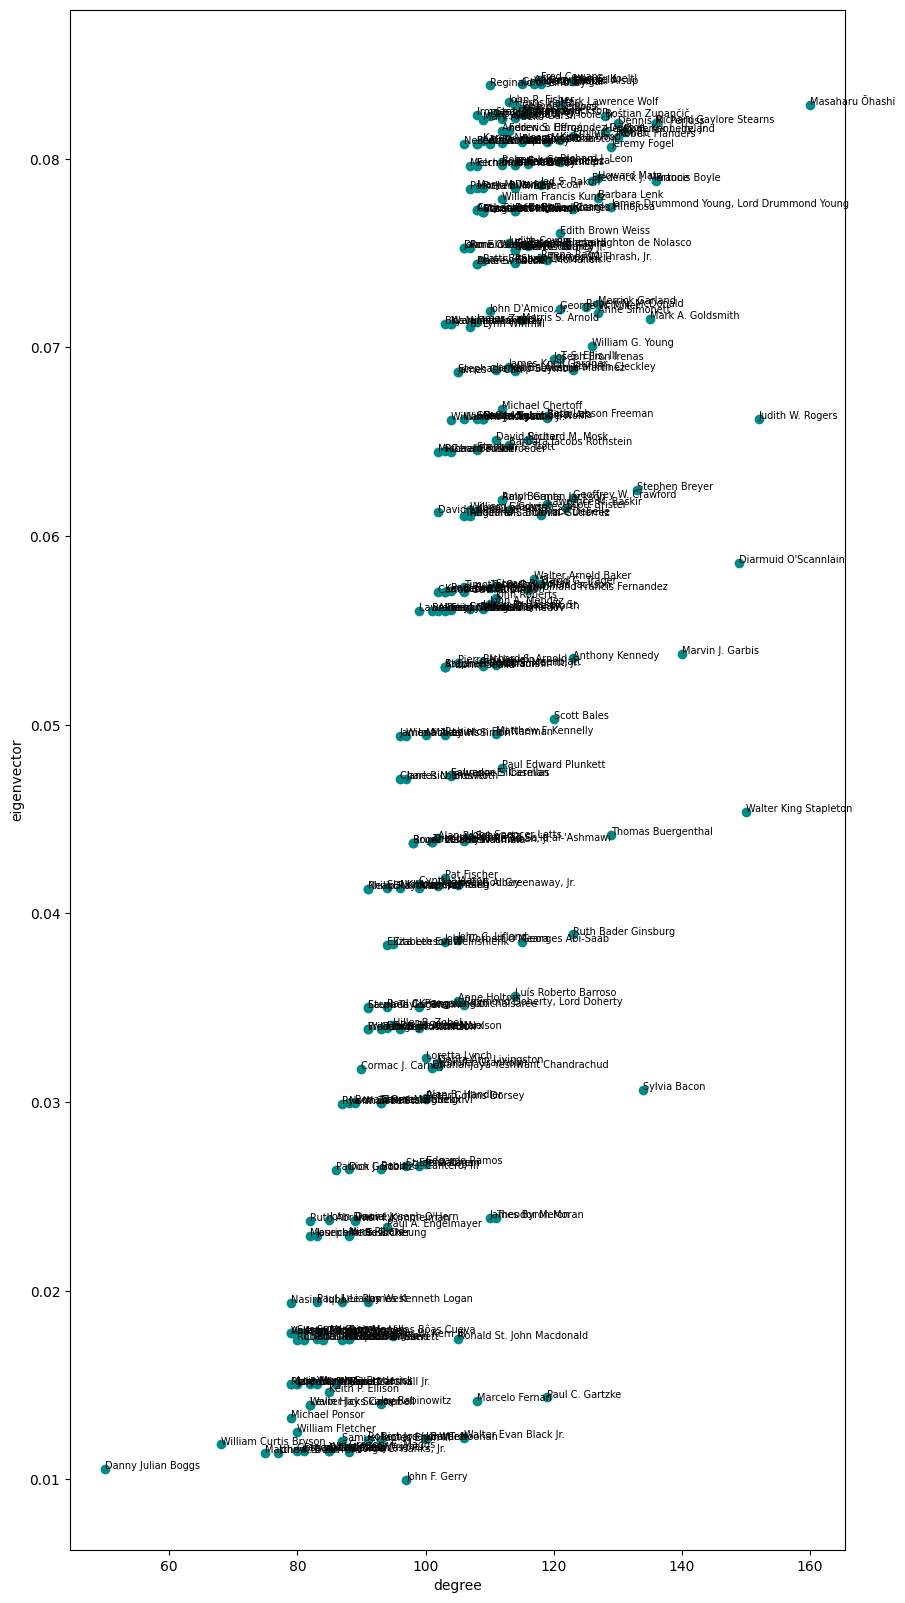

In [190]:
### 

exp = nodes_df.sort_values(by='eigenvector', ascending=False).iloc[:300]

### Adapt image size and police
plt.figure(figsize=(10, 20))

plt.scatter(exp['degree'],
            exp['eigenvector'],
           marker='o',
           color='DarkCyan'
           )
plt.xlabel('degree')
plt.ylabel('eigenvector')

for i,row in list(exp[['label', 'degree','eigenvector']].iterrows()):
    plt.annotate(row['label'],(row['degree'], row['eigenvector']),
                 fontsize=7)
#plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [191]:
persons_high_egv = nodes_df['personUri'][nodes_df.eigenvector> 0.01].to_list()
print(len(persons_high_egv), persons_high_egv[:3])

299 ['http://www.wikidata.org/entity/Q5268914', 'http://www.wikidata.org/entity/Q1807991', 'http://www.wikidata.org/entity/Q4160118']


In [192]:
gr_mer.head(2)

,uriPer_x,uriPer_y,orgs,numberOrgs,uriOrgs,periods_x,BeginY_x,EndY_x,BeginY_y,EndY_y,periods_y
0,http://www.wikidata.org/entity/Q1000439,http://www.wikidata.org/entity/Q109519926,University of Toronto,1,http://www.wikidata.org/entity/Q180865,1925-1949,1945.0,1956.0,1941.0,1952.0,1900-1924
1,http://www.wikidata.org/entity/Q1000439,http://www.wikidata.org/entity/Q176944,University of Toronto,1,http://www.wikidata.org/entity/Q180865,1925-1949,1945.0,1956.0,1949.0,1960.0,1925-1949


In [193]:
connecting_orgs = gr_mer[(gr_mer.uriPer_x.isin(persons_high_egv))|(gr_mer.uriPer_y.isin(persons_high_egv))].groupby(by='orgs').size()
file_add='data/connecting_orgs.csv'
connecting_orgs.sort_values(ascending=False).to_csv(file_add)
print(connecting_orgs.sort_values(ascending=False).iloc[:20])

orgs
Harvard Law School                                  14649
Harvard University                                    319
Princeton University                                  191
Harvard College                                       181
Yale University                                       168
University of Virginia School of Law                  158
Stanford University                                   146
Yale Law School                                       108
Georgetown University Law Center                       69
Harvard Law School|Harvard College                     58
Harvard College|Harvard Law School                     57
University of Michigan                                 56
Duke University                                        54
Dartmouth College                                      53
University of Tokyo                                    53
Columbia University                                    49
Columbia Law School                                    44
Cornell U

### Slicing with cores

In [194]:
### A k-core is a maximal subgraph that contains nodes of degree k or more.
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.core.core_number.html#networkx.algorithms.core.core_number
core_numbers = nx.core_number(big_ppG)

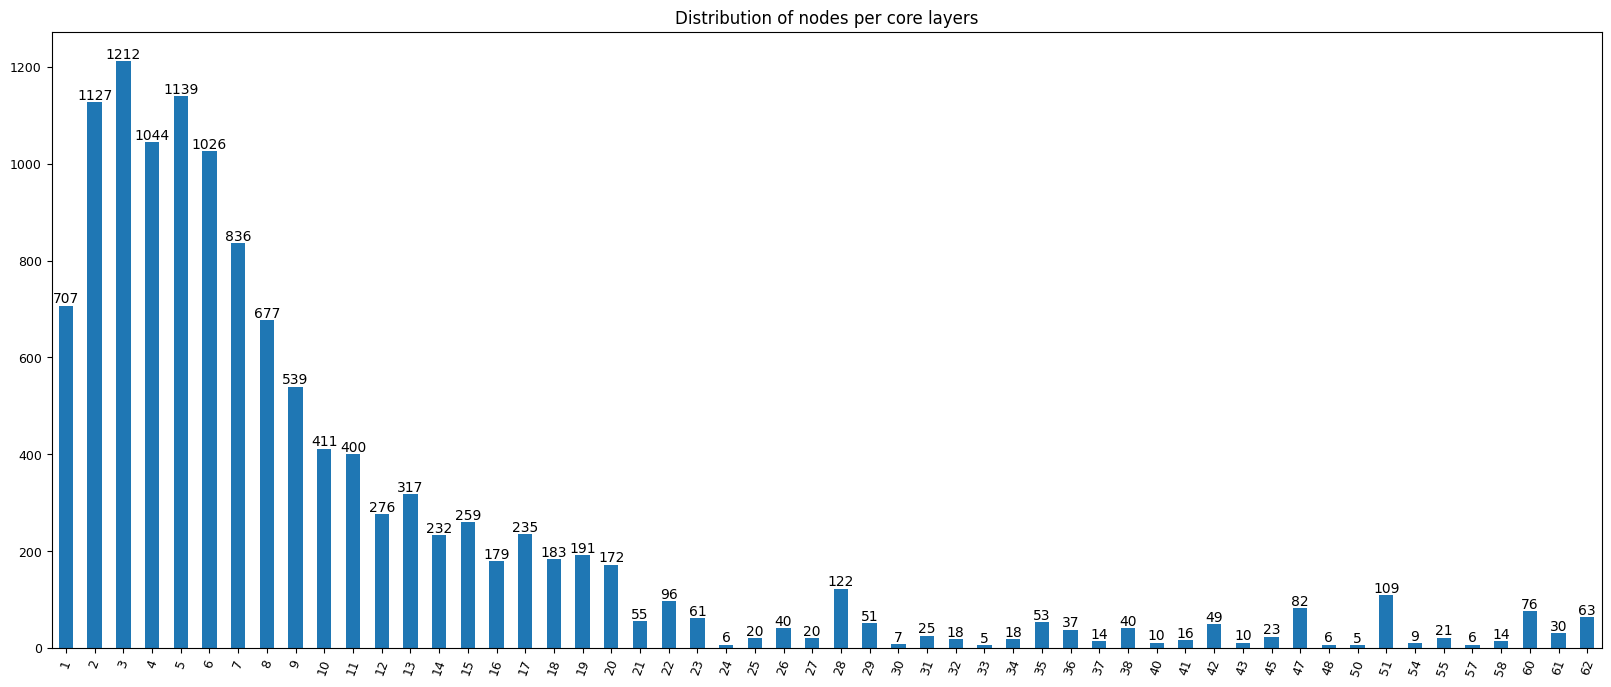

In [195]:
### Distribution of nodes per core layer
l = [v for k,v in core_numbers.items()]
ls = pd.Series(l)
grouped = ls.groupby(ls).size()


ax = grouped.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,8))
plt.title('Distribution of nodes per core layers')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()


In [196]:
# Identify communities based on core numbers
communities = {}
for node, core_number in core_numbers.items():
    if core_number not in communities:
        communities[core_number] = [node]
    else:
        communities[core_number].append(node)

# Print the communities
cts = []
for core_number, community in communities.items():
    # print(f"Community {core_number}: {len(community)}, {community[:5]}")
    cts.append([core_number,len(community),community])



In [197]:
cts=sorted(cts, key=lambda x: x[0])
pprint.pprint([[e[0], e[1] ] for e in cts])

[[1, 707],
 [2, 1127],
 [3, 1212],
 [4, 1044],
 [5, 1139],
 [6, 1026],
 [7, 836],
 [8, 677],
 [9, 539],
 [10, 411],
 [11, 400],
 [12, 276],
 [13, 317],
 [14, 232],
 [15, 259],
 [16, 179],
 [17, 235],
 [18, 183],
 [19, 191],
 [20, 172],
 [21, 55],
 [22, 96],
 [23, 61],
 [24, 6],
 [25, 20],
 [26, 40],
 [27, 20],
 [28, 122],
 [29, 51],
 [30, 7],
 [31, 25],
 [32, 18],
 [33, 5],
 [34, 18],
 [35, 53],
 [36, 37],
 [37, 14],
 [38, 40],
 [40, 10],
 [41, 16],
 [42, 49],
 [43, 10],
 [45, 23],
 [47, 82],
 [48, 6],
 [50, 5],
 [51, 109],
 [54, 9],
 [55, 21],
 [57, 6],
 [58, 14],
 [60, 76],
 [61, 30],
 [62, 63]]


In [202]:
### 
ln = [ k  for k,v in core_numbers.items()  if v >= 62]
print(len(ln), ln[:3])

63 ['http://www.wikidata.org/entity/Q105988316', 'http://www.wikidata.org/entity/Q11436616', 'http://www.wikidata.org/entity/Q15052219']


In [203]:
SG = big_ppG.subgraph(ln)
naf.basic_graph_properties(SG)


{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 63,
 'number_of_edges': 1953,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 1.0}


In [204]:
### Add betweenness to nodes

# !!! trop long sur tout le graphe SI le graph est grand !!!

betweenness = nx.betweenness_centrality(SG)
nx.set_node_attributes(SG, betweenness, 'betweenness')
pprint.pprint(list(SG.nodes.data())[:2])

[('http://www.wikidata.org/entity/Q5163545',
  {'betweenness': 0.0,
   'birthYear': 1950,
   'degree': 109,
   'eigenvector': 0.07716878835828661,
   'label': 'Constance Hunt'}),
 ('http://www.wikidata.org/entity/Q7148511',
  {'betweenness': 0.0,
   'birthYear': 1951,
   'degree': 109,
   'eigenvector': 0.07456053653356452,
   'label': 'Patti B. Saris'})]


In [205]:
### 

g = SG

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 0.4
sc = 0.05

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
#node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
node_size = [n[1]['betweenness']*1000000+10 for n in g.nodes.data()]
#print(node_size)

#dict([tuple(( n[0] , n[1]['label'] ))for n in u.nodes.data()])
node_labels =  dict(((u), 
                    str(d['label']))
                    for u, d in g.nodes(data=True))

node_colors = 'blue'

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.1) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_education_relationships_component_test.svg')
plt.close()
#plt.plot()

## New graphs by period 

In [206]:
gr_mer.head(2)

,uriPer_x,uriPer_y,orgs,numberOrgs,uriOrgs,periods_x,BeginY_x,EndY_x,BeginY_y,EndY_y,periods_y
0,http://www.wikidata.org/entity/Q1000439,http://www.wikidata.org/entity/Q109519926,University of Toronto,1,http://www.wikidata.org/entity/Q180865,1925-1949,1945.0,1956.0,1941.0,1952.0,1900-1924
1,http://www.wikidata.org/entity/Q1000439,http://www.wikidata.org/entity/Q176944,University of Toronto,1,http://www.wikidata.org/entity/Q180865,1925-1949,1945.0,1956.0,1949.0,1960.0,1925-1949


### Period 1875-1899

In [208]:
gr_mer_1850_1899 = gr_mer[(gr_mer.periods_x=='1875-1899')|(gr_mer.periods_y=='1875-1899')].copy(deep=True)
len(gr_mer_1850_1899)

10248

In [209]:
### Distribution of relationships number
print(gr_mer_1850_1899.groupby(by='numberOrgs').size())

numberOrgs
1    9789
2     459
dtype: int64


In [210]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriPer_x'], e['uriPer_y'],
     {'orgsUris':e['uriOrgs'], 'orgsLabels':e['orgs'], 'orgsNumber':e['numberOrgs'],   
      'periods_x':e['periods_x'], 'periods_y':e['periods_y']}
     )) 
     for e in gr_mer_1850_1899.to_dict(orient='records')]
print(len(l))

10248


In [211]:
## Créate the empty graph
ppG=nx.Graph()

## Add relationships to graph
# Multiple rows between two edges are taken only once
ppG.add_edges_from(l)

naf.basic_graph_properties(ppG)


{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 2375,
 'number_of_edges': 10248,
 '------': '------',
 'is connected': False,
 'components': 124,
 'density': 0.0036351704872965903}


In [212]:
### Prepare data to add to nodes
ln = dict([(e['uri'],
     {'label':e['label'], 'birthYear':e['birthYear']}
     ) for e in df_pm.to_dict(orient='records')])
# print(str(l)[:200])


In [213]:

## Add attributes
nx.set_node_attributes(ppG, ln)
pprint.pprint(list(ppG.nodes.data())[:2])


[('http://www.wikidata.org/entity/Q100252086',
  {'birthYear': 1875, 'label': 'John Fletcher Leopold Embury'}),
 ('http://www.wikidata.org/entity/Q109473532',
  {'birthYear': 1869, 'label': 'William Nassau Ferguson'})]


In [214]:
### Create a list of graphs, one per component
perS = [ppG.subgraph(c).copy() for c in nx.connected_components(ppG)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(perS)], key = lambda row: row[1], reverse=True)
print(ln[:5])



[[1, 1856], [20, 27], [75, 15], [49, 14], [51, 13]]


In [215]:
li = [0]
big_ppG = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    big_ppG = nx.union(big_ppG, perS[i])

naf.basic_graph_properties(big_ppG)



{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 3,
 'number_of_edges': 2,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 0.6666666666666666}


In [216]:
### Add degree centrality to nodes
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(big_ppG)])
nx.set_node_attributes(big_ppG, degree)


In [217]:
### Plot degree distribution
d = [d[1] for d in nx.degree(big_ppG)]
naf.describe_plot_integers_distribution(d, 50,6,'Degree distribution')

TypeError: describe_plot_integers_distribution() takes from 2 to 3 positional arguments but 4 were given

In [218]:
### Add eigenvector to nodes

## If error: PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')
# increase number of max iterations
eigenvector = nx.eigenvector_centrality(big_ppG, max_iter=200)
nx.set_node_attributes(big_ppG, eigenvector, 'eigenvector')
pprint.pprint(list(big_ppG.nodes.data())[:2])

[('http://www.wikidata.org/entity/Q109473532',
  {'birthYear': 1869,
   'degree': 1,
   'eigenvector': 0.5000000644180599,
   'label': 'William Nassau Ferguson'}),
 ('http://www.wikidata.org/entity/Q5540187',
  {'birthYear': 1872,
   'degree': 1,
   'eigenvector': 0.5000000644180599,
   'label': 'George Hamilton Pettit'})]


In [219]:
### Plot eigenvector density distribution 
eigenvector_s = pd.Series(list(eigenvector.values()))
stats = eigenvector_s.describe()

# Format decimal values
stats = stats.apply(lambda x: format(x, '.20f'))

print(stats)

count    3.00000000000000000000
mean     0.56903560630725391611
std      0.11957306608013357208
min      0.50000006441805988633
25%      0.50000006441805988633
50%      0.50000006441805988633
75%      0.60355337725185087550
max      0.70710669008564197568
dtype: object


In [220]:
### Export node attributes to dataframe
nodes_data ={node: big_ppG.nodes[node] for node in big_ppG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True)
nodes_df.columns = ['personUri', 'label', 'birthYear','degree','eigenvector']
nodes_df.head(2)

,personUri,label,birthYear,degree,eigenvector
0,http://www.wikidata.org/entity/Q109473532,William Nassau Ferguson,1869,1,0.5
1,http://www.wikidata.org/entity/Q5540187,George Hamilton Pettit,1872,1,0.5


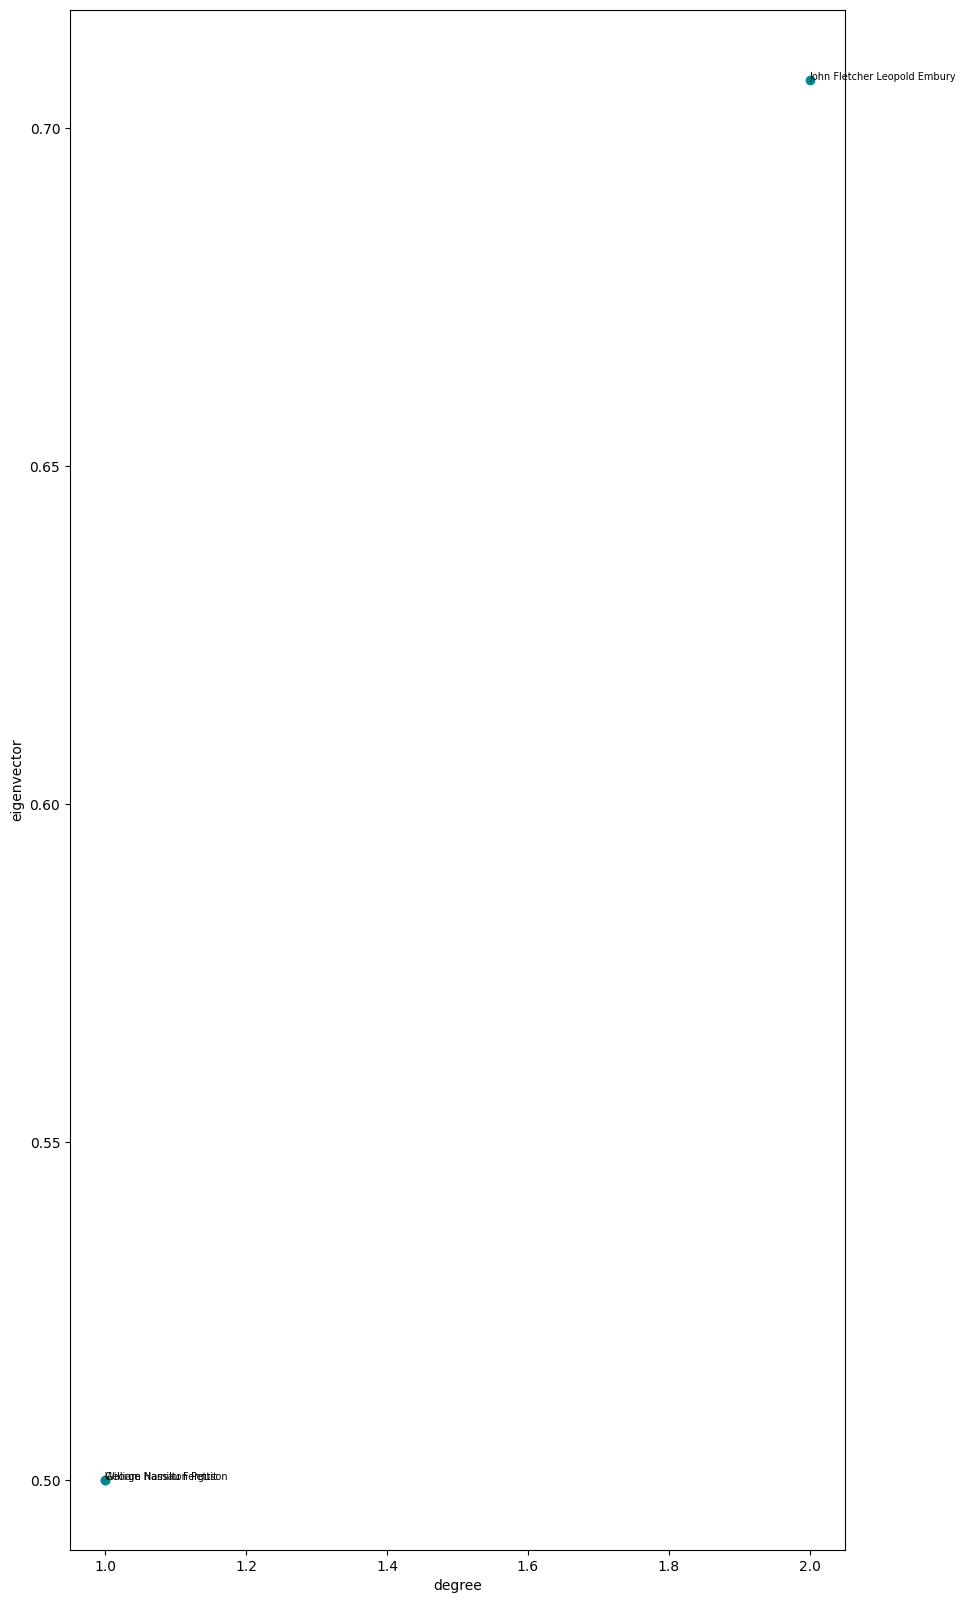

In [221]:
### 

exp = nodes_df.sort_values(by='eigenvector', ascending=False).iloc[:30]

### Adapt image size and police
plt.figure(figsize=(10, 20))

plt.scatter(exp['degree'],
            exp['eigenvector'],
           marker='o',
           color='DarkCyan'
           )
plt.xlabel('degree')
plt.ylabel('eigenvector')

for i,row in list(exp[['label', 'degree','eigenvector']].iterrows()):
    plt.annotate(row['label'],(row['degree'], row['eigenvector']),
                 fontsize=7)
#plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [222]:
persons_high_egv = nodes_df['personUri'][nodes_df.eigenvector> 0.01].to_list()
print(len(persons_high_egv), persons_high_egv[:3])

3 ['http://www.wikidata.org/entity/Q109473532', 'http://www.wikidata.org/entity/Q5540187', 'http://www.wikidata.org/entity/Q100252086']


In [223]:
connecting_orgs = gr_mer[(gr_mer.uriPer_x.isin(persons_high_egv))|(gr_mer.uriPer_y.isin(persons_high_egv))].groupby(by='orgs').size()
# file_add='data/connecting_orgs.csv'
# connecting_orgs.sort_values(ascending=False).to_csv(file_add)
print(connecting_orgs.sort_values(ascending=False).iloc[:20])

orgs
Osgoode Hall Law School    4
dtype: int64


In [224]:
### Add betweenness to nodes

# !!! trop long sur tout le graphe SI le graph est grand !!!

betweenness = nx.betweenness_centrality(big_ppG)
nx.set_node_attributes(big_ppG, betweenness, 'betweenness')


In [225]:
pprint.pprint(list(big_ppG.nodes.data())[:2])

[('http://www.wikidata.org/entity/Q109473532',
  {'betweenness': 0.0,
   'birthYear': 1869,
   'degree': 1,
   'eigenvector': 0.5000000644180599,
   'label': 'William Nassau Ferguson'}),
 ('http://www.wikidata.org/entity/Q5540187',
  {'betweenness': 0.0,
   'birthYear': 1872,
   'degree': 1,
   'eigenvector': 0.5000000644180599,
   'label': 'George Hamilton Pettit'})]


In [226]:
### Export node attributes to dataframe
nodes_data ={node: big_ppG.nodes[node] for node in big_ppG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True)
nodes_df.columns = ['personUri', 'label', 'birthYear','degree','eigenvector', 'betweenness']
nodes_df.head(2)

,personUri,label,birthYear,degree,eigenvector,betweenness
0,http://www.wikidata.org/entity/Q109473532,William Nassau Ferguson,1869,1,0.5,0.0
1,http://www.wikidata.org/entity/Q5540187,George Hamilton Pettit,1872,1,0.5,0.0


In [227]:
nodes_df.sort_values(by=['eigenvector', 'betweenness'], ascending=False).iloc[:30]

,personUri,label,birthYear,degree,eigenvector,betweenness
2,http://www.wikidata.org/entity/Q100252086,John Fletcher Leopold Embury,1875,2,0.707107,1.0
0,http://www.wikidata.org/entity/Q109473532,William Nassau Ferguson,1869,1,0.5,0.0
1,http://www.wikidata.org/entity/Q5540187,George Hamilton Pettit,1872,1,0.5,0.0


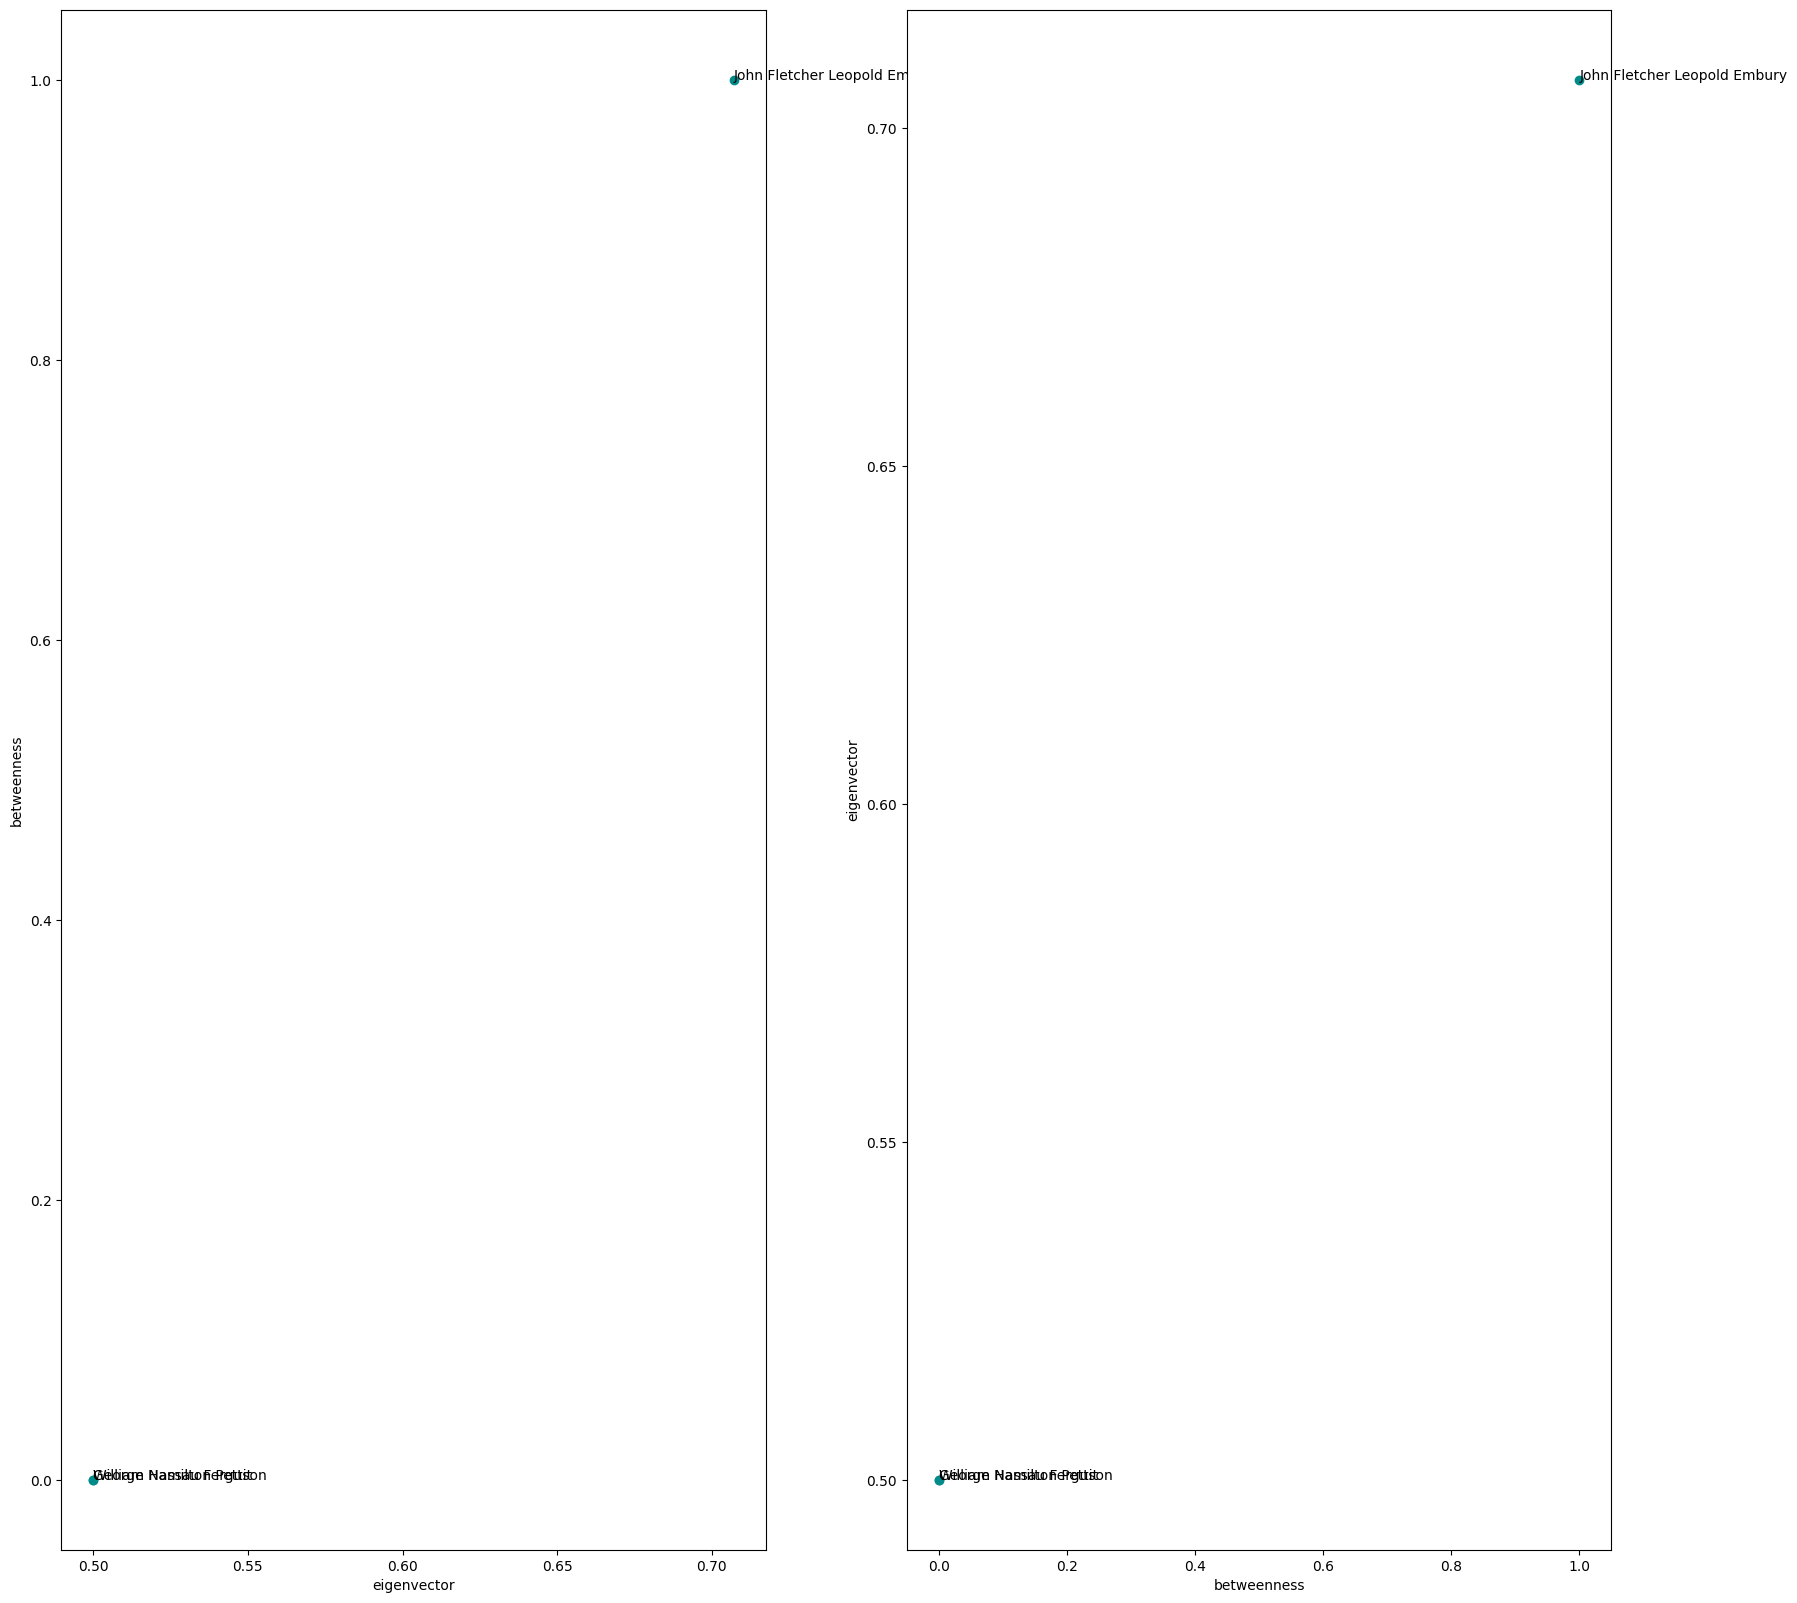

In [228]:
### 



exp_eig = nodes_df.sort_values(by=['eigenvector', 'betweenness'], ascending=False).iloc[:30]
exp_betw = nodes_df.sort_values(by=['betweenness', 'eigenvector'], ascending=False).iloc[:30]

fig, ax = plt.subplots(1,2,figsize=(20,20) ) #  sharey=True, 

ax[0].scatter(exp_eig['eigenvector'],
            exp_eig['betweenness'],
           marker='o',
           color='DarkCyan'
           )
ax[0].set_xlabel('eigenvector')
ax[0].set_ylabel('betweenness')

for i,row in list(exp_eig[['label', 'eigenvector','betweenness']].iterrows()):
    ax[0].annotate(row['label'],(row['eigenvector'], row['betweenness']),
                 fontsize=10)
    

ax[1].scatter(exp_betw['betweenness'],
            exp_betw['eigenvector'],
           marker='o',
           color='DarkCyan'
           )
ax[1].set_xlabel('betweenness')
ax[1].set_ylabel('eigenvector')

for i,row in list(exp_betw[['label', 'betweenness','eigenvector']].iterrows()):
    ax[1].annotate(row['label'],(row['betweenness'], row['eigenvector']),
                 fontsize=10)



#plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

2


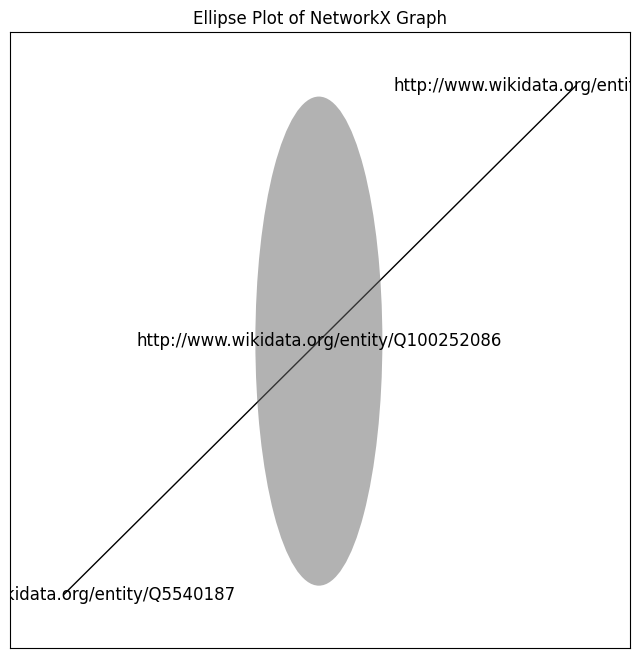

In [229]:

# Visualize the graph with eigenvector centrality

# Position the nodes
pos = nx.spring_layout(big_ppG, k=0.2)

#node_size = [e[1]*500+10 for e in le]
degrees = [d[1] for d in big_ppG.degree()]
max_degree = max(degrees)
print(max_degree)


cmap = plt.get_cmap('Dark2')


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8,8))

# Draw the nodes and edges
#nx.draw_networkx_nodes(big_ppG, pos, ax=ax)
nx.draw_networkx_edges(big_ppG, pos, ax=ax)

# Create the ellipses
for node in big_ppG.nodes():
    width = big_ppG.nodes[node]['eigenvector']*0.7
    height = big_ppG.nodes[node]['betweenness']*0.7
    x, y = pos[node]
    degree = big_ppG.degree(node)
    color = cmap(degree / max_degree)
    ellipse = patches.Ellipse((x, y), width, height, alpha=0.5, facecolor=color)
    ax.add_patch(ellipse)
nx.draw_networkx_labels(big_ppG, pos) # ,  horizontalalignment='left'
# Set the limits and labels
#ax.set_xlim(min(pos.values(), key=lambda x: x[0])[0] - 10, max(pos.values(), key=lambda x: x[0])[0] + 10)
#ax.set_ylim(min(pos.values(), key=lambda x: x[1])[1] - 10, max(pos.values(), key=lambda x: x[1])[1] + 10)
ax.set_title('Ellipse Plot of NetworkX Graph')


plt.show()

In [230]:
### betweenness distribution 
betweenness_s = pd.Series(list(betweenness.values()))

stats = betweenness_s.describe()

# Format decimal values
stats = stats.apply(lambda x: format(x, '.20f'))

print(stats)

count    3.00000000000000000000
mean     0.33333333333333331483
std      0.57735026918962584208
min      0.00000000000000000000
25%      0.00000000000000000000
50%      0.00000000000000000000
75%      0.50000000000000000000
max      1.00000000000000000000
dtype: object


In [231]:
### 

g = big_ppG

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 0.4
sc = 0.05

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
#node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
node_size = [n[1]['betweenness']*1000000+10 for n in g.nodes.data()]
#print(node_size)

#dict([tuple(( n[0] , n[1]['label'] ))for n in u.nodes.data()])
node_labels =  dict(((u), 
                    str(d['label']))
                    for u, d in g.nodes(data=True))

node_colors = 'blue'

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.1) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_education_relationships_component_1851_1900.svg')
plt.close()
#plt.plot()

C:\Users\tangu\AppData\Local\Temp\ipykernel_16468\140851357.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=50)


In [232]:
### A k-core is a maximal subgraph that contains nodes of degree k or more.
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.core.core_number.html#networkx.algorithms.core.core_number
core_numbers = nx.core_number(big_ppG)

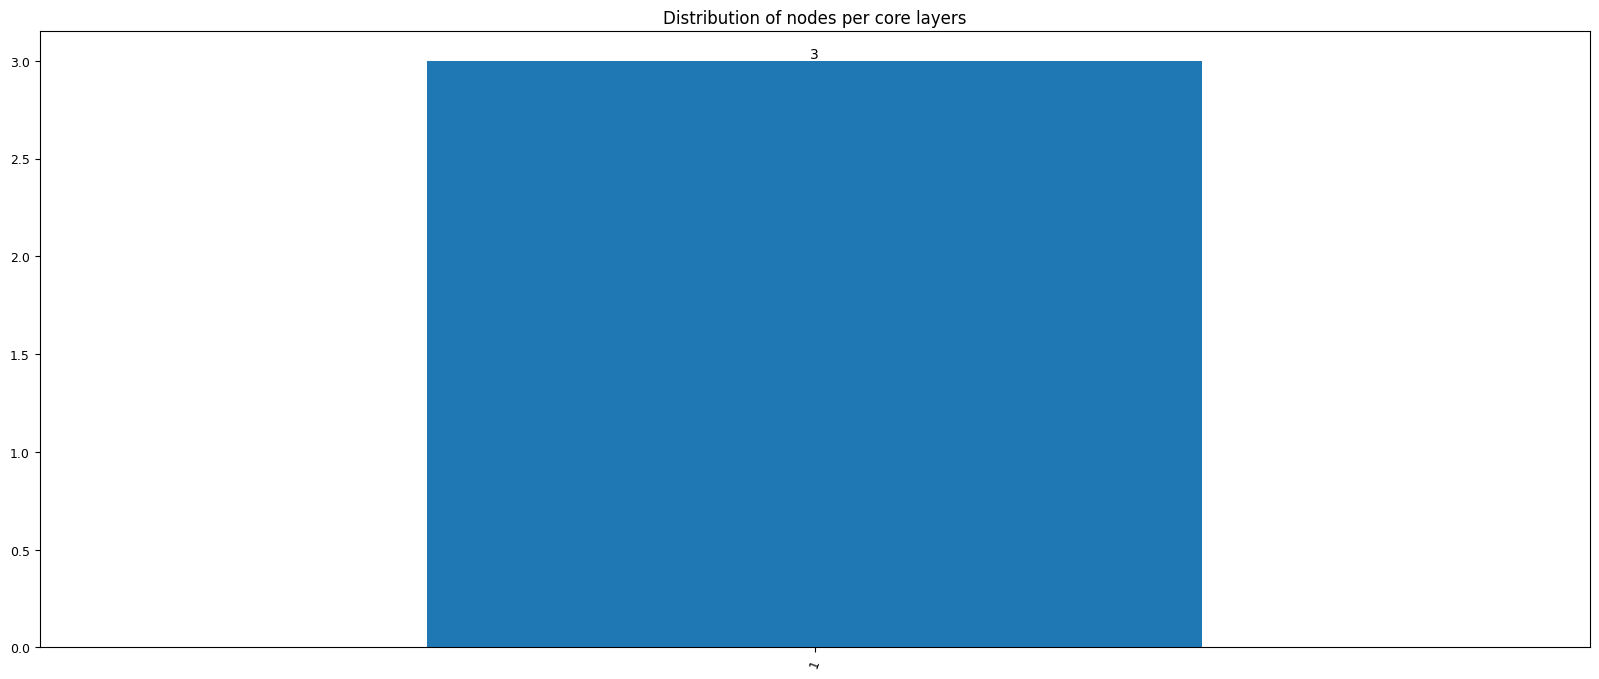

In [233]:
### Distribution of nodes per core layer
l = [v for k,v in core_numbers.items()]
ls = pd.Series(l)
grouped = ls.groupby(ls).size()


ax = grouped.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,8))
plt.title('Distribution of nodes per core layers')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()


In [240]:
### 
ln = [ k  for k,v in core_numbers.items()  if v > 0]
print(len(ln), ln[:3])

3 ['http://www.wikidata.org/entity/Q109473532', 'http://www.wikidata.org/entity/Q5540187', 'http://www.wikidata.org/entity/Q100252086']


In [241]:
naf.basic_graph_properties(big_ppG)

{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 3,
 'number_of_edges': 2,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 0.6666666666666666}


In [242]:
SG = big_ppG.subgraph(ln)
naf.basic_graph_properties(SG)


{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 3,
 'number_of_edges': 2,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 0.6666666666666666}


In [246]:
b = betweenness_s.sort_values(ascending=False).iloc[2]
print(b)

0.0


In [247]:
### 

g = SG

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 0.7
sc = 0.05

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
#node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
node_size = [n[1]['betweenness']*500000+20 for n in g.nodes.data()]
#print(node_size)



## label only for the 10 most relevant intermediaries
node_labels =  dict(((u), 
                    str(d['label']))
                    if d['betweenness'] > b 
                    else ((u), 
                    str(''))
                    for u, d in g.nodes(data=True))
print(node_labels)

node_colors = 'blue'

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_sliced_education_relationships_component_1851_1900.svg')
plt.close()
#plt.plot()

{'http://www.wikidata.org/entity/Q109473532': '', 'http://www.wikidata.org/entity/Q5540187': '', 'http://www.wikidata.org/entity/Q100252086': 'John Fletcher Leopold Embury'}


C:\Users\tangu\AppData\Local\Temp\ipykernel_16468\4176133944.py:58: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=50)


#### Egograph based on eigenvector

In [248]:
ei = sorted([n[1]['eigenvector'] for n in big_ppG.nodes.data()], reverse=True)[10]
print(ei)

IndexError: list index out of range

In [249]:
ln = [n[0] for n in big_ppG.nodes.data() if n[1]['eigenvector'] >= ei ]
print(len(ln), ln[1])

NameError: name 'ei' is not defined

In [250]:
ego_graph = nx.ego_graph(big_ppG, ln[1], radius=2)
egn = list(ego_graph.nodes())
print(egn[:2])

['http://www.wikidata.org/entity/Q109473532', 'http://www.wikidata.org/entity/Q5540187']


In [251]:

# Display variable

egos_graph = nx.Graph()

l_nodes=[]
i = 0
while i < len(ln):
    ego_graph = nx.ego_graph(big_ppG, ln[1], radius=3)
    egn = list(ego_graph.nodes())
    l_nodes += egn
    i += 1

egos_graph = nx.subgraph(big_ppG, l_nodes)

naf.basic_graph_properties(egos_graph)


{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 3,
 'number_of_edges': 2,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 0.6666666666666666}


In [252]:
pprint.pprint(list(egos_graph.nodes.data())[:2])

[('http://www.wikidata.org/entity/Q109473532',
  {'betweenness': 0.0,
   'birthYear': 1869,
   'degree': 1,
   'eigenvector': 0.5000000644180599,
   'label': 'William Nassau Ferguson'}),
 ('http://www.wikidata.org/entity/Q5540187',
  {'betweenness': 0.0,
   'birthYear': 1872,
   'degree': 1,
   'eigenvector': 0.5000000644180599,
   'label': 'George Hamilton Pettit'})]


In [253]:
ei2 = sorted([n[1]['eigenvector'] for n in big_ppG.nodes.data()], reverse=True)[50]
print(ei2)

IndexError: list index out of range

In [254]:
### 

g = egos_graph

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 0.7
sc = 0.05

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
#node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
node_size = [n[1]['eigenvector']*50000+20 for n in g.nodes.data()]
#print(node_size)



## label only for the 10 most relevant intermediaries
node_labels =  dict(((u), 
                    str(d['label']))
                    if d['eigenvector'] >= ei2
                    else ((u), 
                    str(''))
                    for u, d in g.nodes(data=True))
#print(node_labels)

node_colors = 'blue'

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_egos_education_relationships_component_1851_1900.svg')
plt.close()
#plt.plot()

NameError: name 'ei2' is not defined

<Figure size 1098.61x1098.61 with 0 Axes>

In [255]:
### Export node attributes to dataframe
nodes_data ={node: egos_graph.nodes[node] for node in egos_graph.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True)
nodes_df.columns = ['personUri', 'label', 'birthYear','degree','eigenvector', 'betweenness']
nodes_df.head(2)

,personUri,label,birthYear,degree,eigenvector,betweenness
0,http://www.wikidata.org/entity/Q109473532,William Nassau Ferguson,1869,1,0.5,0.0
1,http://www.wikidata.org/entity/Q5540187,George Hamilton Pettit,1872,1,0.5,0.0


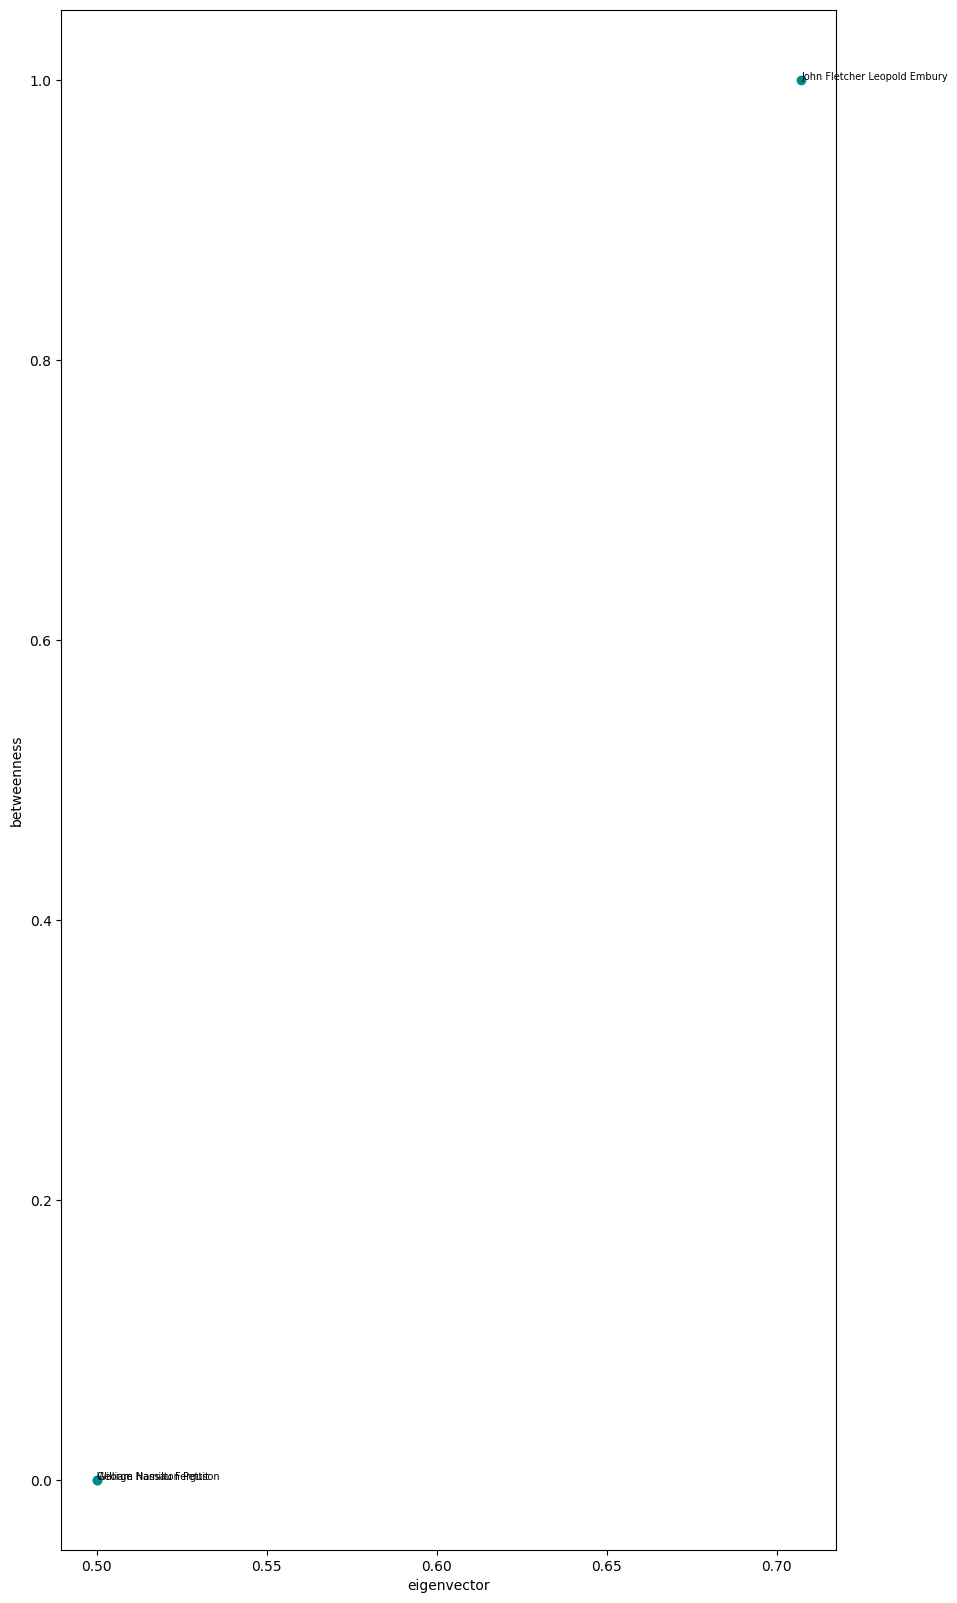

In [256]:
### 

exp = nodes_df.sort_values(by='betweenness', ascending=False).iloc[:50]

### Adapt image size and police
plt.figure(figsize=(10, 20))

plt.scatter(exp['eigenvector'],
           exp['betweenness'],
            marker='o',
           color='DarkCyan'
           )
plt.xlabel('eigenvector')
plt.ylabel('betweenness')

for i,row in list(exp[['label','eigenvector', 'betweenness']].iterrows()):
    plt.annotate(row['label'],( row['eigenvector'],row['betweenness']),
                 fontsize=7)
#plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [257]:
persons_high_egv = nodes_df['personUri'][nodes_df.eigenvector> ei2].to_list()
print(len(persons_high_egv), persons_high_egv[:3])

NameError: name 'ei2' is not defined

In [258]:
connecting_orgs = gr_mer[(gr_mer.uriPer_x.isin(persons_high_egv))|(gr_mer.uriPer_y.isin(persons_high_egv))].groupby(by='orgs').size()
# file_add='data/connecting_orgs.csv'
# connecting_orgs.sort_values(ascending=False).to_csv(file_add)
print(connecting_orgs.sort_values(ascending=False).iloc[:20])

orgs
Osgoode Hall Law School    4
dtype: int64


# Conclusion

Reste à faire:

* ajouter les poids sur les relations pour calcules les paramètres de centralité
* vérifier s'il y a une correlation entre prix obtenus et centralité dans le réseau des études
* vérifier s'il y a correlation entre étudier ensemble et publier ensemble 

### Period 1901-1920

In [259]:
gr_mer_1901_1920 = gr_mer[(gr_mer.periods_x=='1900-1924')|(gr_mer.periods_y=='1900-1924')].copy(deep=True)
print(len(gr_mer_1901_1920))

19540


In [260]:
### Distribution of relationships number
print(gr_mer_1901_1920.groupby(by='numberOrgs').size())

numberOrgs
1    18522
2     1007
3       11
dtype: int64


In [261]:
## Provide the data in the format 
# required by Networkx

l = [tuple(
    (e['uriPer_x'], e['uriPer_y'],
     {'orgsUris':e['uriOrgs'], 'orgsLabels':e['orgs'], 'orgsNumber':e['numberOrgs'],   
      'periods_x':e['periods_x'], 'periods_y':e['periods_y']}
     )) 
     for e in gr_mer_1901_1920.to_dict(orient='records')]
print(len(l))

19540


In [262]:
## Créate the empty graph
ppG=nx.Graph()

## Add relationships to graph
# Multiple rows between two edges are taken only once
ppG.add_edges_from(l)

naf.basic_graph_properties(ppG)


{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 3356,
 'number_of_edges': 19540,
 '------': '------',
 'is connected': False,
 'components': 147,
 'density': 0.0034708838319694336}


In [263]:
### Prepare data to add to nodes
ln = dict([(e['uri'],
     {'label':e['label'], 'birthYear':e['birthYear']}
     ) for e in df_pm.to_dict(orient='records')])
# print(str(l)[:200])


In [264]:

## Add attributes
nx.set_node_attributes(ppG, ln)
pprint.pprint(list(ppG.nodes.data())[:2])


[('http://www.wikidata.org/entity/Q1000439',
  {'birthYear': 1927, 'label': 'Bud Cullen'}),
 ('http://www.wikidata.org/entity/Q109519926',
  {'birthYear': 1923, 'label': 'Sydney Lewis Robins'})]


In [265]:
### Create a list of graphs, one per component
perS = [ppG.subgraph(c).copy() for c in nx.connected_components(ppG)]

### i is the component index in the list S of graphs , len(s.nodes) is the nomber of nodes
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(perS)], key = lambda row: row[1], reverse=True)
print(ln[:5])



[[0, 2699], [36, 28], [61, 28], [15, 25], [55, 24]]


In [266]:
li = [0]
big_ppG = nx.Graph()
for i in li:
    ## ajoute au graphe les composantes en utilisant
    # l'index ou position dans la liste de graphes 'S'
    big_ppG = nx.union(big_ppG, perS[i])

naf.basic_graph_properties(big_ppG)



{'is_multigraph': False,
 'is_directed': False,
 'number_of_nodes': 2699,
 'number_of_edges': 18403,
 '------': '------',
 'is connected': True,
 'components': 1,
 'density': 0.005054448686620611}


In [267]:
### Add degree centrality to nodes
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(big_ppG)])
nx.set_node_attributes(big_ppG, degree)


In [268]:
### Plot degree distribution
d = [d[1] for d in nx.degree(big_ppG)]
naf.describe_plot_integers_distribution(d, 50,6,'Degree distribution')

TypeError: describe_plot_integers_distribution() takes from 2 to 3 positional arguments but 4 were given

In [269]:
### Add eigenvector to nodes

## If error: PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')
# increase number of max iterations
eigenvector = nx.eigenvector_centrality(big_ppG, max_iter=200)
nx.set_node_attributes(big_ppG, eigenvector, 'eigenvector')
pprint.pprint(list(big_ppG.nodes.data())[:2])

[('http://www.wikidata.org/entity/Q1000439',
  {'birthYear': 1927,
   'degree': 1,
   'eigenvector': 0.001070631697201029,
   'label': 'Bud Cullen'}),
 ('http://www.wikidata.org/entity/Q109519926',
  {'birthYear': 1923,
   'degree': 84,
   'eigenvector': 0.07744470300893758,
   'label': 'Sydney Lewis Robins'})]


In [270]:
### Plot eigenvector density distribution 
eigenvector_s = pd.Series(list(eigenvector.values()))
stats = eigenvector_s.describe()

# Format decimal values
stats = stats.apply(lambda x: format(x, '.20f'))

print(stats)

count    2699.00000000000000000000
mean        0.00523373663420192200
std         0.01852681220024059855
min         0.00000000000000000011
25%         0.00000014327626123519
50%         0.00002679102176736519
75%         0.00086208363290458251
max         0.10618998618048469673
dtype: object


In [271]:
### Export node attributes to dataframe
nodes_data ={node: big_ppG.nodes[node] for node in big_ppG.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True)
nodes_df.columns = ['personUri', 'label', 'birthYear','degree','eigenvector']
nodes_df.head(2)

,personUri,label,birthYear,degree,eigenvector
0,http://www.wikidata.org/entity/Q1000439,Bud Cullen,1927,1,0.001071
1,http://www.wikidata.org/entity/Q109519926,Sydney Lewis Robins,1923,84,0.077445


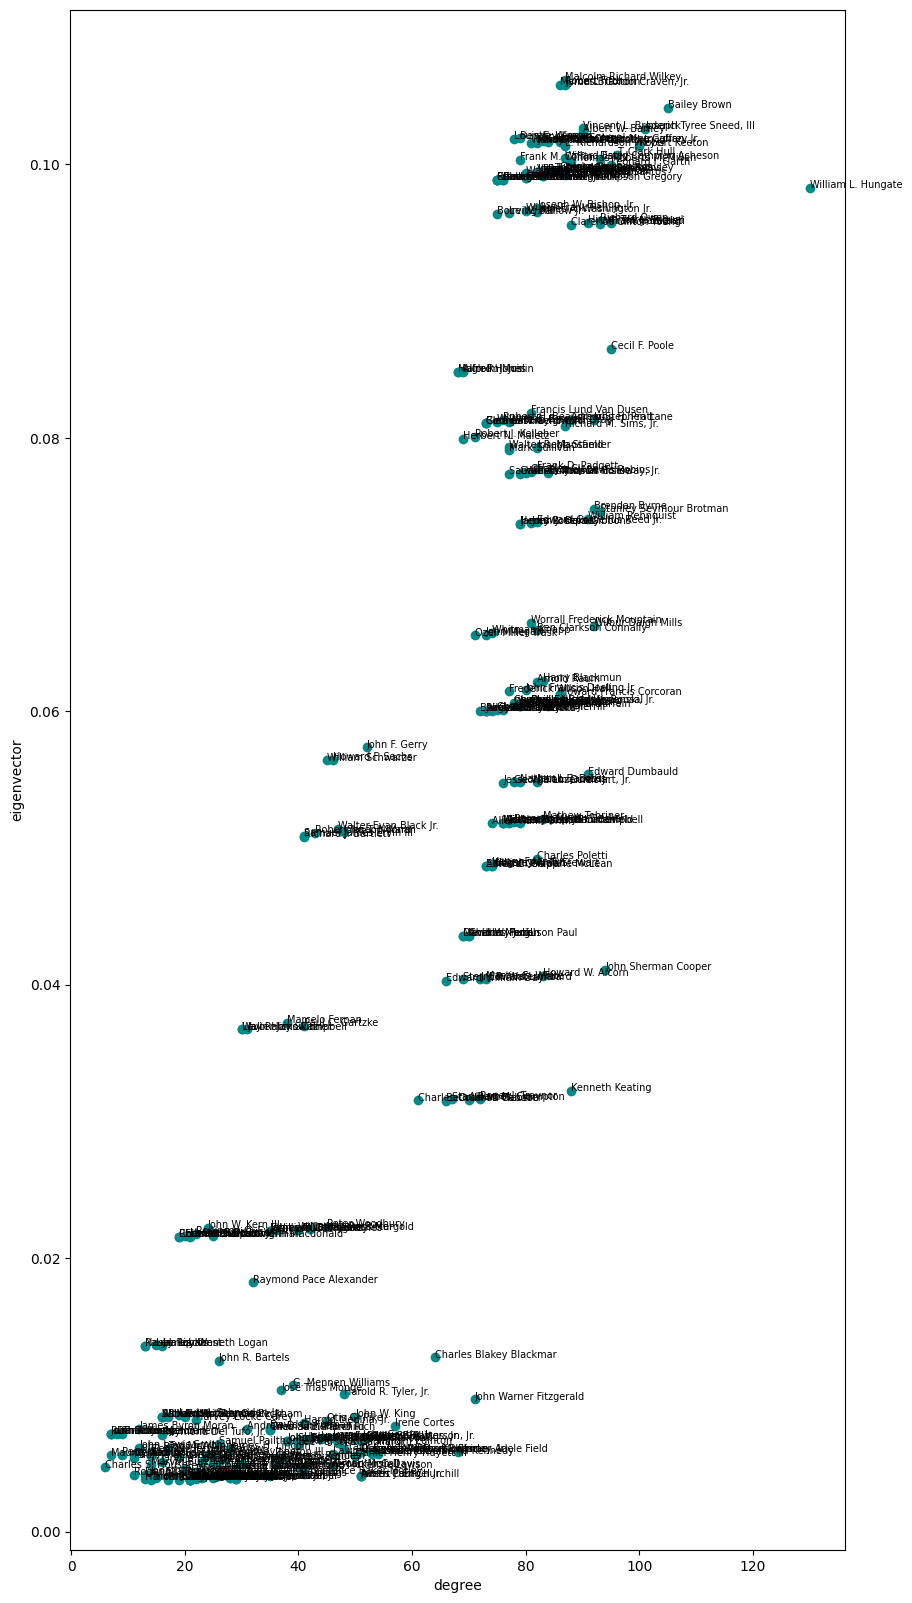

In [272]:
### 

exp = nodes_df.sort_values(by='eigenvector', ascending=False).iloc[:300]

### Adapt image size and police
plt.figure(figsize=(10, 20))

plt.scatter(exp['degree'],
            exp['eigenvector'],
           marker='o',
           color='DarkCyan'
           )
plt.xlabel('degree')
plt.ylabel('eigenvector')

for i,row in list(exp[['label', 'degree','eigenvector']].iterrows()):
    plt.annotate(row['label'],(row['degree'], row['eigenvector']),
                 fontsize=7)
#plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [273]:
persons_high_egv = nodes_df['personUri'][nodes_df.eigenvector> 0.01].to_list()
print(len(persons_high_egv), persons_high_egv[:3])

192 ['http://www.wikidata.org/entity/Q109519926', 'http://www.wikidata.org/entity/Q5541885', 'http://www.wikidata.org/entity/Q4848339']


In [274]:
connecting_orgs = gr_mer[(gr_mer.uriPer_x.isin(persons_high_egv))|(gr_mer.uriPer_y.isin(persons_high_egv))].groupby(by='orgs').size()
# file_add='data/connecting_orgs.csv'
# connecting_orgs.sort_values(ascending=False).to_csv(file_add)
print(connecting_orgs.sort_values(ascending=False).iloc[:20])

orgs
Harvard Law School                                          7423
Princeton University                                         138
Harvard University                                           112
University of Michigan                                        80
primary school                                                75
University of Texas School of Law                             60
Yale University                                               59
Columbia Law School                                           47
University of Michigan|University of Michigan Law School      40
Dartmouth College                                             39
Harvard College                                               33
University of Virginia School of Law                          30
University of Michigan Law School                             29
Stanford University                                           27
University of London                                          25
Columbia University 

In [275]:
### Add betweenness to nodes

# !!! trop long sur tout le graphe SI le graph est grand !!!

betweenness = nx.betweenness_centrality(big_ppG)
nx.set_node_attributes(big_ppG, betweenness, 'betweenness')
pprint.pprint(list(big_ppG.nodes.data())[:2])

[('http://www.wikidata.org/entity/Q1000439',
  {'betweenness': 0.0,
   'birthYear': 1927,
   'degree': 1,
   'eigenvector': 0.001070631697201029,
   'label': 'Bud Cullen'}),
 ('http://www.wikidata.org/entity/Q109519926',
  {'betweenness': 0.015084392074839357,
   'birthYear': 1923,
   'degree': 84,
   'eigenvector': 0.07744470300893758,
   'label': 'Sydney Lewis Robins'})]


In [ ]:
print([e[1] for e in list(betweenness.items())][:3])

In [ ]:
### betweenness distribution 
betweenness_s = pd.Series(list(betweenness.values()))

stats = betweenness_s.describe()

# Format decimal values
stats = stats.apply(lambda x: format(x, '.20f'))

print(stats)

In [ ]:
### A k-core is a maximal subgraph that contains nodes of degree k or more.
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.core.core_number.html#networkx.algorithms.core.core_number
core_numbers = nx.core_number(big_ppG)

In [ ]:
### Distribution of nodes per core layer
l = [v for k,v in core_numbers.items()]
ls = pd.Series(l)
grouped = ls.groupby(ls).size()


ax = grouped.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,8))
plt.title('Distribution of nodes per core layers')

## https://stackoverflow.com/questions/71320380/add-only-the-total-values-on-top-of-stacked-bars
ax.bar_label(ax.containers[-1])

plt.show()


In [ ]:
### 
ln = [ k  for k,v in core_numbers.items()  if v > 10]
print(len(ln), ln[:3])

In [ ]:
naf.basic_graph_properties(big_ppG)

In [ ]:
SG = big_ppG.subgraph(ln)
naf.basic_graph_properties(SG)


In [ ]:
b = betweenness_s.sort_values(ascending=False).iloc[40]
print(b)

In [ ]:
### 

g = SG

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 0.7
sc = 0.05

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
#node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
node_size = [n[1]['betweenness']*500000+20 for n in g.nodes.data()]
#print(node_size)



## label only for the 10 most relevant intermediaries
node_labels =  dict(((u), 
                    str(d['label']))
                    if d['betweenness'] > b 
                    else ((u), 
                    str(''))
                    for u, d in g.nodes(data=True))
#print(node_labels)

node_colors = 'blue'

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_sliced_education_relationships_component_1901_1920.svg')
plt.close()
#plt.plot()

#### Egograph based on eigenvector

In [ ]:
ei = sorted([n[1]['eigenvector'] for n in big_ppG.nodes.data()], reverse=True)[10]
print(ei)

In [ ]:
ln = [n[0] for n in big_ppG.nodes.data() if n[1]['eigenvector'] >= ei ]
print(len(ln), ln[1])

In [ ]:
ego_graph = nx.ego_graph(big_ppG, ln[1], radius=2)
egn = list(ego_graph.nodes())
print(egn[:2])

In [ ]:

# Display variable

egos_graph = nx.Graph()

l_nodes=[]
i = 0
while i < len(ln):
    ego_graph = nx.ego_graph(big_ppG, ln[1], radius=3)
    egn = list(ego_graph.nodes())
    l_nodes += egn
    i += 1

egos_graph = nx.subgraph(big_ppG, l_nodes)

naf.basic_graph_properties(egos_graph)


In [ ]:
pprint.pprint(list(egos_graph.nodes.data())[:2])

In [ ]:
ei2 = sorted([n[1]['eigenvector'] for n in big_ppG.nodes.data()], reverse=True)[50]
print(ei2)

In [ ]:
### 

g = egos_graph

n_size = np.log(np.sqrt(nx.number_of_nodes(g)))* 20 #*25

graph_layout = 'spring_layout'
n_k = 0.7
sc = 0.05

### Define the layout, i.e. the choice 
# of the algorithm for the representation of the graph.

if graph_layout == 'fruchterman_reingold':
    pos = nx.fruchterman_reingold_layout(g)
elif graph_layout == 'kamada_kawai':
    pos = nx.kamada_kawai_layout(g)
elif graph_layout == 'spring_layout':
    pos = nx.spring_layout(g, k = n_k, scale=sc)  
else:
    pos = nx.kamada_kawai_layout(g)




# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (n_size,n_size))



## on définit ici l'algorythme avec lequel le traphe sera représenté

# node_size = [d[1]*100 for d in nx.degree(g)]
#node_size = [d[1]*10000 for d in nx.eigenvector_centrality(g).items()]
node_size = [n[1]['eigenvector']*50000+20 for n in g.nodes.data()]
#print(node_size)



## label only for the 10 most relevant intermediaries
node_labels =  dict(((u), 
                    str(d['label']))
                    if d['eigenvector'] >= ei2
                    else ((u), 
                    str(''))
                    for u, d in g.nodes(data=True))
#print(node_labels)

node_colors = 'blue'

### On représente successivement les différentes sommets et arêtes,
# puis on ajoute les labels
nx.draw_networkx_nodes(g, pos,  node_color=node_colors, node_size=node_size, alpha=0.2)
nx.draw_networkx_edges(g, pos, alpha=0.02) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=node_labels, alpha=0.8, font_size=20)

### On peut augmenter ou diminuer ce paramètre pour ajuster le graphe
plt.tight_layout(pad=50)
plt.savefig('images/biggest_egos_education_relationships_component_1901_1920.svg')
plt.close()
#plt.plot()

In [ ]:
### Export node attributes to dataframe
nodes_data ={node: egos_graph.nodes[node] for node in egos_graph.nodes}
nodes_df = pd.DataFrame(nodes_data).T
nodes_df.reset_index(inplace=True)
nodes_df.columns = ['personUri', 'label', 'birthYear','degree','eigenvector', 'betweenness']
nodes_df.head(2)

In [ ]:
### 

exp = nodes_df.sort_values(by='betweenness', ascending=False).iloc[:100]

### Adapt image size and police
plt.figure(figsize=(10, 20))

plt.scatter(exp['eigenvector'],
           exp['betweenness'],
            marker='o',
           color='DarkCyan'
           )
plt.xlabel('eigenvector')
plt.ylabel('betweenness')

for i,row in list(exp[['label','eigenvector', 'betweenness']].iterrows()):
    plt.annotate(row['label'],( row['eigenvector'],row['betweenness']),
                 fontsize=7)
#plt.legend(title='Node type')
#plt.savefig('plots/sieges_eigenvector_20210526.jpg')
plt.show()

In [ ]:
persons_high_egv = nodes_df['personUri'][nodes_df.eigenvector> ei2].to_list()
print(len(persons_high_egv), persons_high_egv[:3])

In [ ]:
connecting_orgs = gr_mer[(gr_mer.uriPer_x.isin(persons_high_egv))|(gr_mer.uriPer_y.isin(persons_high_egv))].groupby(by='orgs').size()
# file_add='data/connecting_orgs.csv'
# connecting_orgs.sort_values(ascending=False).to_csv(file_add)
print(connecting_orgs.sort_values(ascending=False).iloc[:20])